In [1]:
import os
import numpy as np
import pandas as pd

import json
import pickle

# import cfdna_covid19

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
font_size = 10
rc={'font.size': font_size, 'axes.labelsize': font_size, 'figure.dpi':400, 'axes.linewidth':1, 'axes.edgecolor':'k',
    'axes.titlesize': font_size, 'xtick.labelsize': font_size, 'ytick.labelsize': font_size} # 'figure.figsize':(11.7/1.5,8.27/1.5)

flatui_3risk = ['#e41a1c','#4daf4a','#ff7f00']
flatui_2cls = ['#377eb8', '#984ea3']

flatui = ['#ff7f00','#4daf4a','#984ea3','#377eb8', '#e41a1c']

sns.set(style='ticks',rc=rc) #talk, ticks, paper
sns.set_context("paper")
# sns.palplot(sns.color_palette(flatui))

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
plt.rcParams['axes.unicode_minus']=False # negative minus sign

centimeter = 1/2.54  # centimeter in inches


In [8]:
import sklearn
print('sklearn:'+sklearn.__version__)

from sklearn import metrics
from scipy import stats

import shap
print ('shap:' + shap.__version__)

import hyperopt
print ('hyperopt:' + hyperopt.__version__)

sklearn:0.23.2
shap:0.39.0
hyperopt:0.2.5


In [4]:
# load tss-gene name
tss_gene_ls_fname = r'~/20211104_model_feature/tss_177_trans_and_169gene.list'
tss_gene_df = pd.read_csv(tss_gene_ls_fname,sep='\t',names=['tss','gene','trans'], header=None)


In [5]:
tss_gene_df.head(10)

tss         gene                                trans
0  gene_1_33376      TNFAIP3  NM_001270508,NM_001270507,NM_006290
1  gene_1_33425         PEX3                            NM_003630
2  gene_0_33456         GRM1            NM_001278067,NM_001278066
3  gene_0_33543       MTRF1L                         NM_001301872
4  gene_0_33574       ARID1B                         NM_001363725
5  gene_0_33589       DYNLT1  NM_001291603,NM_001291602,NM_006519
6  gene_0_33593      EZR-AS1                            NR_102425
7  gene_0_33599      C6orf99                            NR_160979
8  gene_1_33678  RPS6KA2-AS1                            NR_046644
9  gene_0_33702    KIF25-AS1                            NR_103750

In [6]:
model_re_root_dir = r'~/model'

raw_data_dir = r'~/data'

feat_types = 'lab, fragl, tss, motif, m2model'

map_name= {'lab': 'LABModel', 'fragl': 'FRAGLModel', 'tss': 'TSSModel', 'motif': 'MOTIFModel', 'm2model': 'M2Model'}

raw_data_fnames={'lab':'399_labtest_fill.csv', 'fragl':'insert.399s.data.csv', 'tss':'tss.fillna.pkl', 'motif':'399_patients_motif_proportion.csv'}


In [7]:
max_feat_idx_ap = {'lab': 14, 'fragl': 6, 'tss': 31, 'motif': 28, 'm2model': 20}
def load_feat_importance_shap(i_feat_type, return_all=False):
    feat_imp_df = pd.read_csv(os.path.join(model_re_root_dir,i_feat_type+'/33_fl_feature_importance_shap.csv'), sep='\t')
    if return_all:
        return feat_imp_df
    else:
        return feat_imp_df.iloc[:max_feat_idx_ap[i_feat_type]+1,:]

def load_all_feats_name():
    lab_feat_imp_df = pd.read_csv(os.path.join(model_re_root_dir,'lab/33_fl_feature_importance_shap.csv'), sep='\t')
    fragl_feat_imp_df = pd.read_csv(os.path.join(model_re_root_dir,'fragl/33_fl_feature_importance_shap.csv'), sep='\t')
    tss_feat_imp_df = pd.read_csv(os.path.join(model_re_root_dir,'tss/33_fl_feature_importance_shap.csv'), sep='\t')
    motif_feat_imp_df = pd.read_csv(os.path.join(model_re_root_dir,'motif/33_fl_feature_importance_shap.csv'), sep='\t')
    
    feat_names = {}
    feat_names['lab']=lab_feat_imp_df['feat_name'].values
    feat_names['fragl']=fragl_feat_imp_df['feat_name'].values
    feat_names['tss']=tss_feat_imp_df['feat_name'].values
    feat_names['motif']=motif_feat_imp_df['feat_name'].values
    
    return feat_names
    

# Focal Loss Model - M2Model

## SHAP plot

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


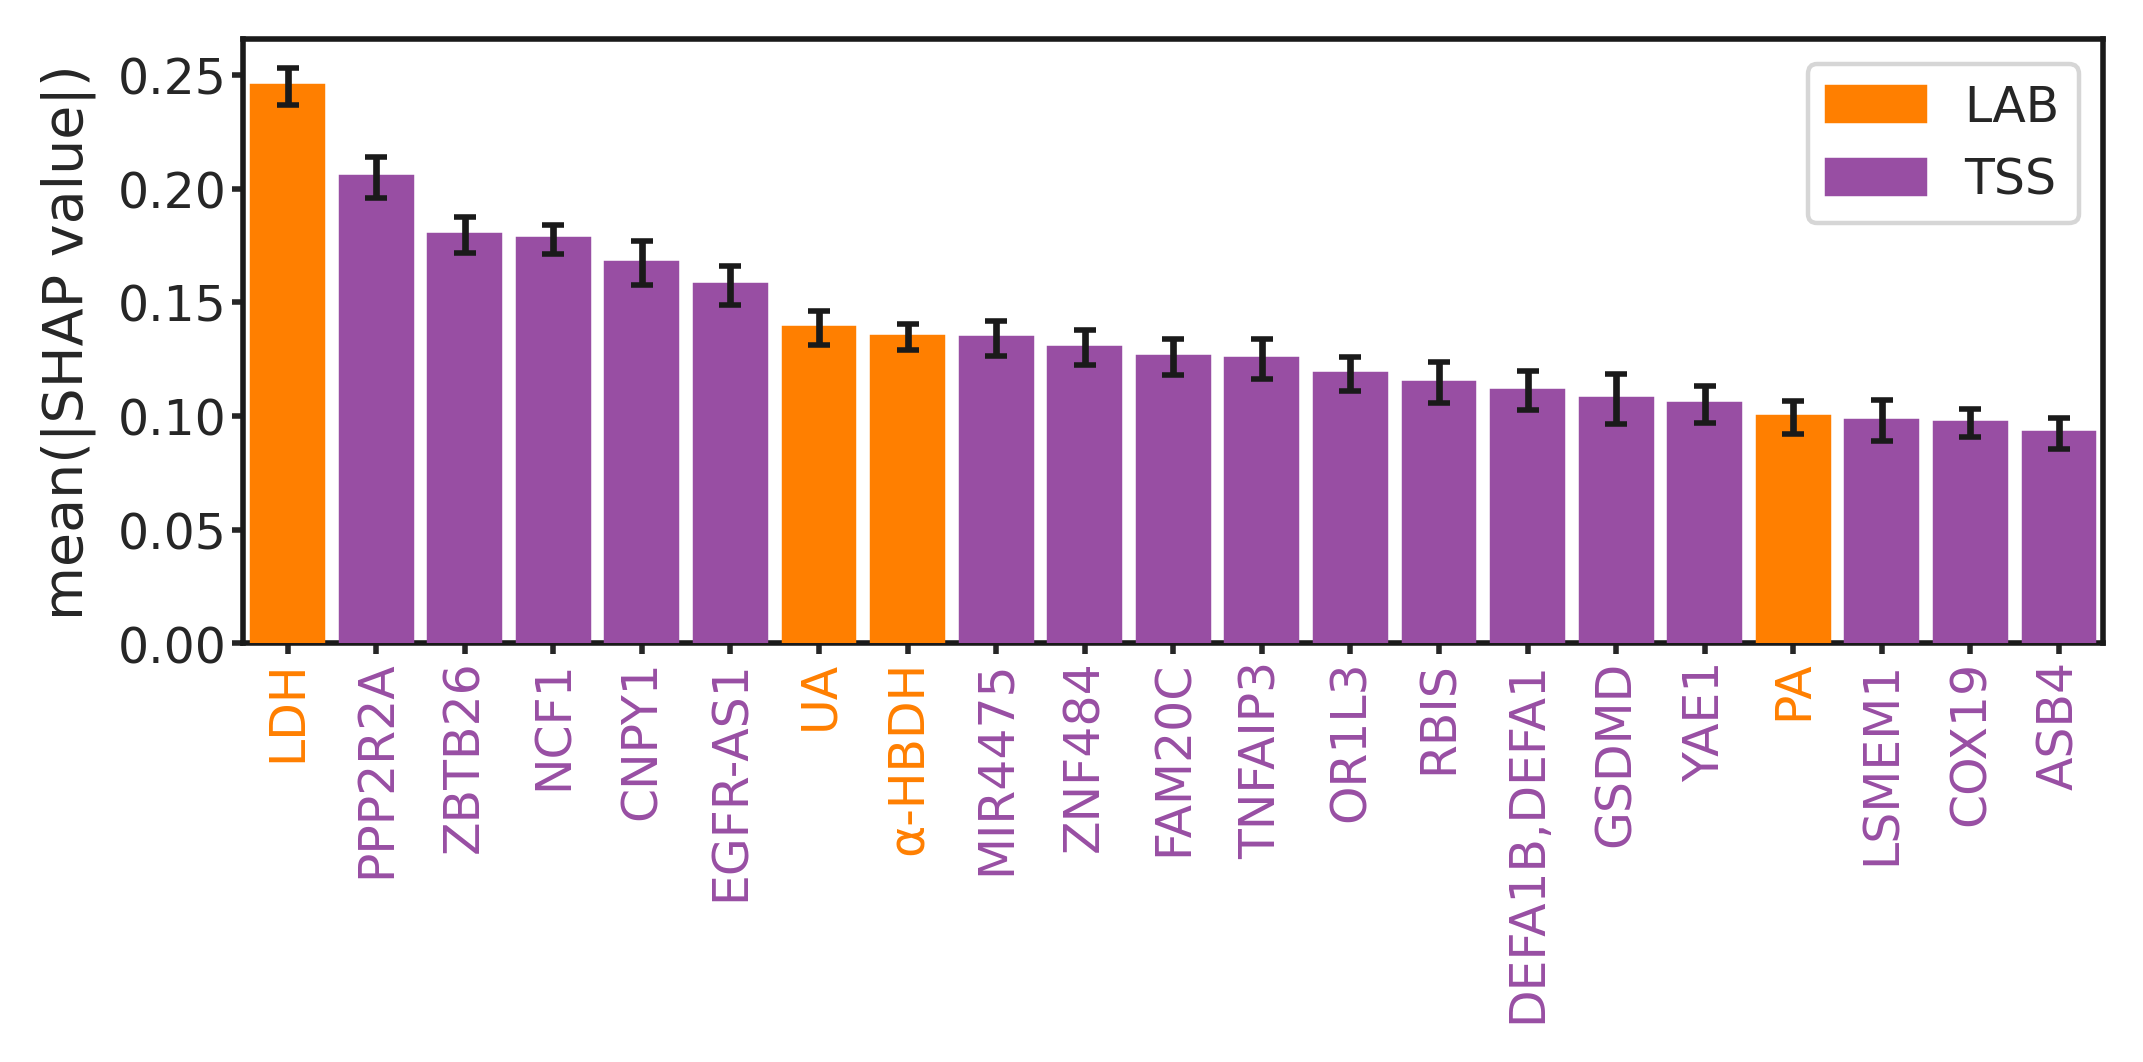

In [131]:
colorss_map = dict(zip('lab,fragl,tss,motif'.split(','), ['#ff7f00','#4daf4a','#984ea3','#377eb8']))
feat_typess = [x.strip() for x in feat_types.split(',')]
ix = 4 # for m2model

i_feat_type = feat_typess[ix]
fig, ax = plt.subplots(1,1, figsize=(6,2))
shaps = load_feat_importance_shap(i_feat_type)
# shapss = shaps.copy()
# shapss['se']=stats.sem(shaps.iloc[:,1:-2].values,axis=1)
# shapss
# https://www.python-graph-gallery.com/8-add-confidence-interval-on-barplot
barWidth = 0.8
x_pos = np.arange(max_feat_idx_ap[i_feat_type]+1)

f_type = [] # feature types 
f_color=[]

if i_feat_type =='fragl':
    a = 103
    b=[]
    b.append(a)
    while a<=250:
        a = a+10.4
        b.append(a)
    b = np.array([int(x) for x in b])
    xxticks = ['{}~{}bp'.format(x, b[np.argwhere(b==x)+1][0,0]) for x in shaps['feat_name'].values]
    
elif i_feat_type =='tss':
    genes = [tss_gene_df.loc[tss_gene_df['tss']==x, 'gene'].values[0] for x in shaps['feat_name'].values]
    # geness = ['DEFA1' if x == 'DEFA1B,DEFA1' else x for x in genes] 
    # xxticks = [r'$\it{}$'.format(x) for x in geness]
    xxticks = genes
    
elif i_feat_type =='m2model':
    xxticks = []
    featnames = load_all_feats_name()
    m2model_feats = shaps['feat_name'].values
    
    for f in m2model_feats:
        for iiidx, t in enumerate('lab,fragl,tss,motif'.split(',')):
            if f in featnames[t]:
                f_type.append(t)
                f_color.append(flatui[iiidx])
                break
                
    for ii_dx,ft in enumerate(f_type):
        if ft == 'tss':
            gene = tss_gene_df.loc[tss_gene_df['tss']==m2model_feats[ii_dx], 'gene'].values[0]
            # if gene == 'DEFA1B,DEFA1':
            #     gene = 'DEFA1'
            # xxticks.append(r'$\it{}$'.format(gene)
            xxticks.append(gene)
        else:
            if  m2model_feats[ii_dx] == 'Uric_acid':
                xxticks.append('UA')
            else:
                xxticks.append(m2model_feats[ii_dx])   
else:
    xxticks = ['UA' if x == 'Uric_acid' else x for x in shaps['feat_name'].values]
    
if i_feat_type =='m2model':
    
    ax.bar(x_pos, shaps['feat_shap_mean'].values, 
           width = barWidth, color = f_color , 
           edgecolor=f_color,zorder=5,
           yerr=shaps['feat_shap_std'].values/10,capsize=2) # n=100 iterations(samples)
    plt.xticks(x_pos, xxticks,rotation=90)
    xlbls = ax.get_xmajorticklabels()
    for iidx, lbl in enumerate(xlbls):
        lbl.set_color(f_color[iidx])  
else:
    ax.bar(x_pos, shaps['feat_shap_mean'].values, 
           width = barWidth, color = flatui[ix] , 
           yerr=(shaps['feat_shap_std'].values)/10, capsize=2)
    plt.xticks(x_pos, xxticks,rotation=90)

plt.xlim(min(x_pos)-0.5,max(x_pos)+0.5)  
plt.ylabel('mean(|SHAP value|)', fontsize=10)

handles = [plt.Rectangle((0,0),1,1, color=colorss_map[label]) for label in np.unique(f_type)]

if len(f_type)>0: 
    plt.legend(handles, [x.upper() for x in np.unique(f_type)])

plt.tick_params(direction='out', length=2, pad=1, width=1)

plt.savefig("results_plt/feat_importance_{}_n{}.pdf".format(i_feat_type, max_feat_idx_ap[i_feat_type]+1), 
            dpi=400, bbox_inches='tight', format='pdf')

In [134]:
shaps

feat_name  0_mean_abs_shap  1_mean_abs_shap  2_mean_abs_shap  \
0            LDH         0.154199         0.230776         0.156471   
1   gene_0_36079         0.086962         0.237622         0.187002   
2   gene_1_38365         0.103305         0.170722         0.161648   
3   gene_1_34557         0.182872         0.096968         0.141076   
4   gene_1_35660         0.206250         0.272829         0.150808   
5   gene_0_34371         0.107618         0.187185         0.228227   
6      Uric_acid         0.173548         0.087166         0.254795   
7         α-HBDH         0.210880         0.084231         0.155508   
8   gene_1_37604         0.216210         0.155272         0.004011   
9   gene_0_37969         0.266222         0.139557         0.138789   
10  gene_0_33748         0.251455         0.201060         0.133167   
11  gene_1_33376         0.200892         0.153172         0.000000   
12  gene_0_38356         0.117025         0.077916         0.137431   
13  gene_1_36592         0.000000         0.204485         0.102000   
14  gene_0_35754         0.208729         0.213477         0.094210   
15  gene_0_37102         0.238929         0.048231         0.265666   
16  gene_0_34227         0.135512         0.056864         0.123587   
17            PA         0.095519         0.136220         0.000000   
18  gene_0_35092         0.136265         0.079860         0.267801   
19  gene_1_33775         0.089641         0.120235         0.082242   
20  gene_1_34781         0.032628         0.115276         0.045444   

    3_mean_abs_shap  4_mean_abs_shap  5_mean_abs_shap  6_mean_abs_shap  \
0          0.348959         0.325206         0.106830         0.532530   
1          0.078213         0.317125         0.099468         0.096203   
2          0.362449         0.115870         0.087566         0.032805   
3          0.114618         0.102487         0.127865         0.198341   
4          0.214391         0.136373         0.160733         0.091494   
5          0.108451         0.339965         0.129219         0.178959   
6          0.147581         0.116425         0.078478         0.161420   
7          0.098706         0.128972         0.220863         0.078306   
8          0.048910         0.085611         0.059503         0.206419   
9          0.168355         0.028000         0.048472         0.086455   
10         0.135353         0.142878         0.312291         0.125406   
11         0.119862         0.063867         0.028092         0.214512   
12         0.101921         0.178868         0.000000         0.085636   
13         0.180855         0.040303         0.024427         0.067363   
14         0.000000         0.132603         0.255011         0.217573   
15         0.137474         0.164370         0.085141         0.084922   
16         0.153508         0.149527         0.326839         0.012499   
17         0.010192         0.061676         0.154368         0.135711   
18         0.010211         0.052341         0.105065         0.000000   
19         0.000000         0.107032         0.103287         0.068867   
20         0.046807         0.046841         0.158925         0.173311   

    7_mean_abs_shap  8_mean_abs_shap  ...  92_mean_abs_shap  93_mean_abs_shap  \
0          0.155545         0.214826  ...          0.295763          0.416351   
1          0.362537         0.155329  ...          0.191542          0.010182   
2          0.273637         0.247246  ...          0.124655          0.205333   
3          0.186972         0.147091  ...          0.111861          0.225165   
4          0.000000         0.208530  ...          0.037893          0.024810   
5          0.100390         0.162895  ...          0.244255          0.044345   
6          0.070831         0.042246  ...          0.067613          0.000000   
7          0.088567         0.174182  ...          0.216032          0.086768   
8          0.145617         0.222958  ...          0.166283          0.171811   
9    

In [135]:
shaps.sum(0)

feat_name           LDHgene_0_36079gene_1_38365gene_1_34557gene_1_...
0_mean_abs_shap                                               3.21466
1_mean_abs_shap                                               3.06912
2_mean_abs_shap                                               2.82988
3_mean_abs_shap                                               2.58682
                                          ...                        
97_mean_abs_shap                                              3.01173
98_mean_abs_shap                                              2.65911
99_mean_abs_shap                                              3.05545
feat_shap_mean                                                2.86377
feat_shap_std                                                 1.68784
Length: 103, dtype: object

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


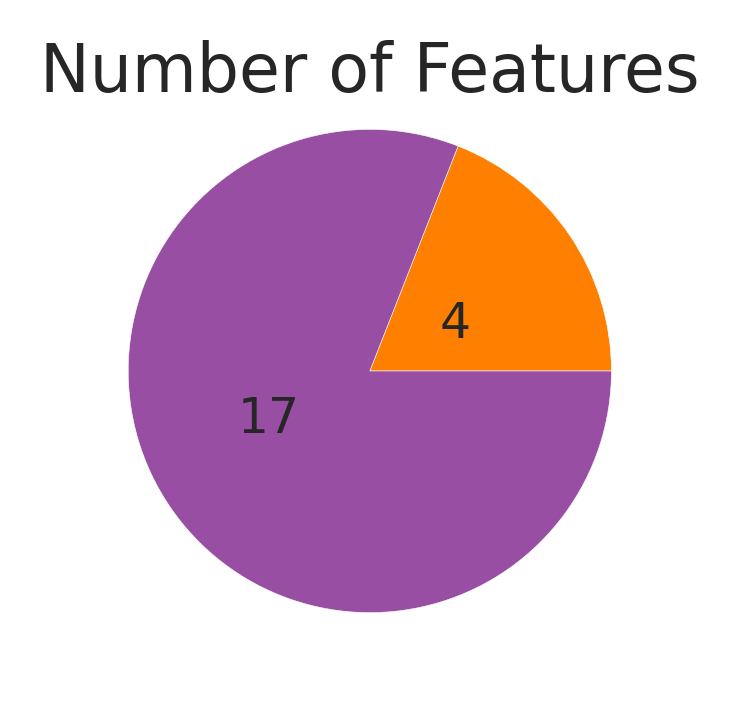

In [18]:
assert i_feat_type == 'm2model'

fig, ax = plt.subplots(1,1, figsize=(2,2))
# feature size
values, counts = np.unique(f_type, return_counts=True)
# Create a pieplot
plt.pie(counts, labels=counts, labeldistance=0.35, colors=[colorss_map[label] for label in values], 
        wedgeprops = { 'linewidth' : 0.1, 'edgecolor' : 'white' })
ax.set_title('Number of Features',fontsize=12, y=1.0, pad=-4)

plt.savefig("results_plt/feat_importance_proc_{}_n{}.pdf".format(i_feat_type, max_feat_idx_ap[i_feat_type]+1), dpi=400, bbox_inches='tight')

## Feature Distribution

For lab,fragl,tss,motif

In [26]:
fd_types = 'lab,fragl,tss,motif'.split(',')

iidx = 3
fd_iidx_type = fd_types[iidx]

# {'lab': 15, 'fragl': 7, 'tss': 32, 'motif': 29} 
fd_feat_names = load_feat_importance_shap(fd_iidx_type)['feat_name'].values
fd_feat_names = [str(x) for x in fd_feat_names]
if fd_iidx_type == 'tss':
    with open(os.path.join(raw_data_dir, raw_data_fnames[fd_iidx_type]), 'rb') as f:
        fd_raw_dat = pickle.load(f)[['ind','label']+fd_feat_names].copy()
    fd_raw_dat.rename(columns={"label": "new_triage"}, inplace=True)
else:
    fd_raw_dat = pd.read_csv(os.path.join(raw_data_dir, raw_data_fnames[fd_iidx_type]))

if fd_iidx_type == 'fragl':
    fd_sel_dat=fd_raw_dat[['ind','label']+ fd_feat_names].copy()
    fd_sel_dat.rename(columns={'label':'new_triage'}, inplace=True)
else:
    fd_sel_dat=fd_raw_dat[['ind','new_triage']+ fd_feat_names].copy()

fd_sel_dat['labels']=fd_sel_dat['new_triage'].apply(lambda x: 'Noncritical' if x ==0 else 'Critical')
orders = ['Noncritical','Critical']
palette = dict(zip(orders, ['#2ecc71','#e74c3c']))


/zfssz2/ST_MCHRI/BIGDATA/USER/baiyong/anaconda3/lib/python3.6/site-packages/statannotations/Annotator.py:795: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "
/zfssz2/ST_MCHRI/BIGDATA/USER/baiyong/anaconda3/lib/python3.6/site-packages/statannotations/Annotator.py:795: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "
/zfssz2/ST_MCHRI/BIGDATA/USER/baiyong/anaconda3/lib/python3.6/site-packages/statannotations/Annotator.py:795: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "
/zfssz2/ST_MCHRI/BIGDATA/USER/baiyong/anaconda3/lib/python3.6/site-packages/statannotations/Annotator.py:7

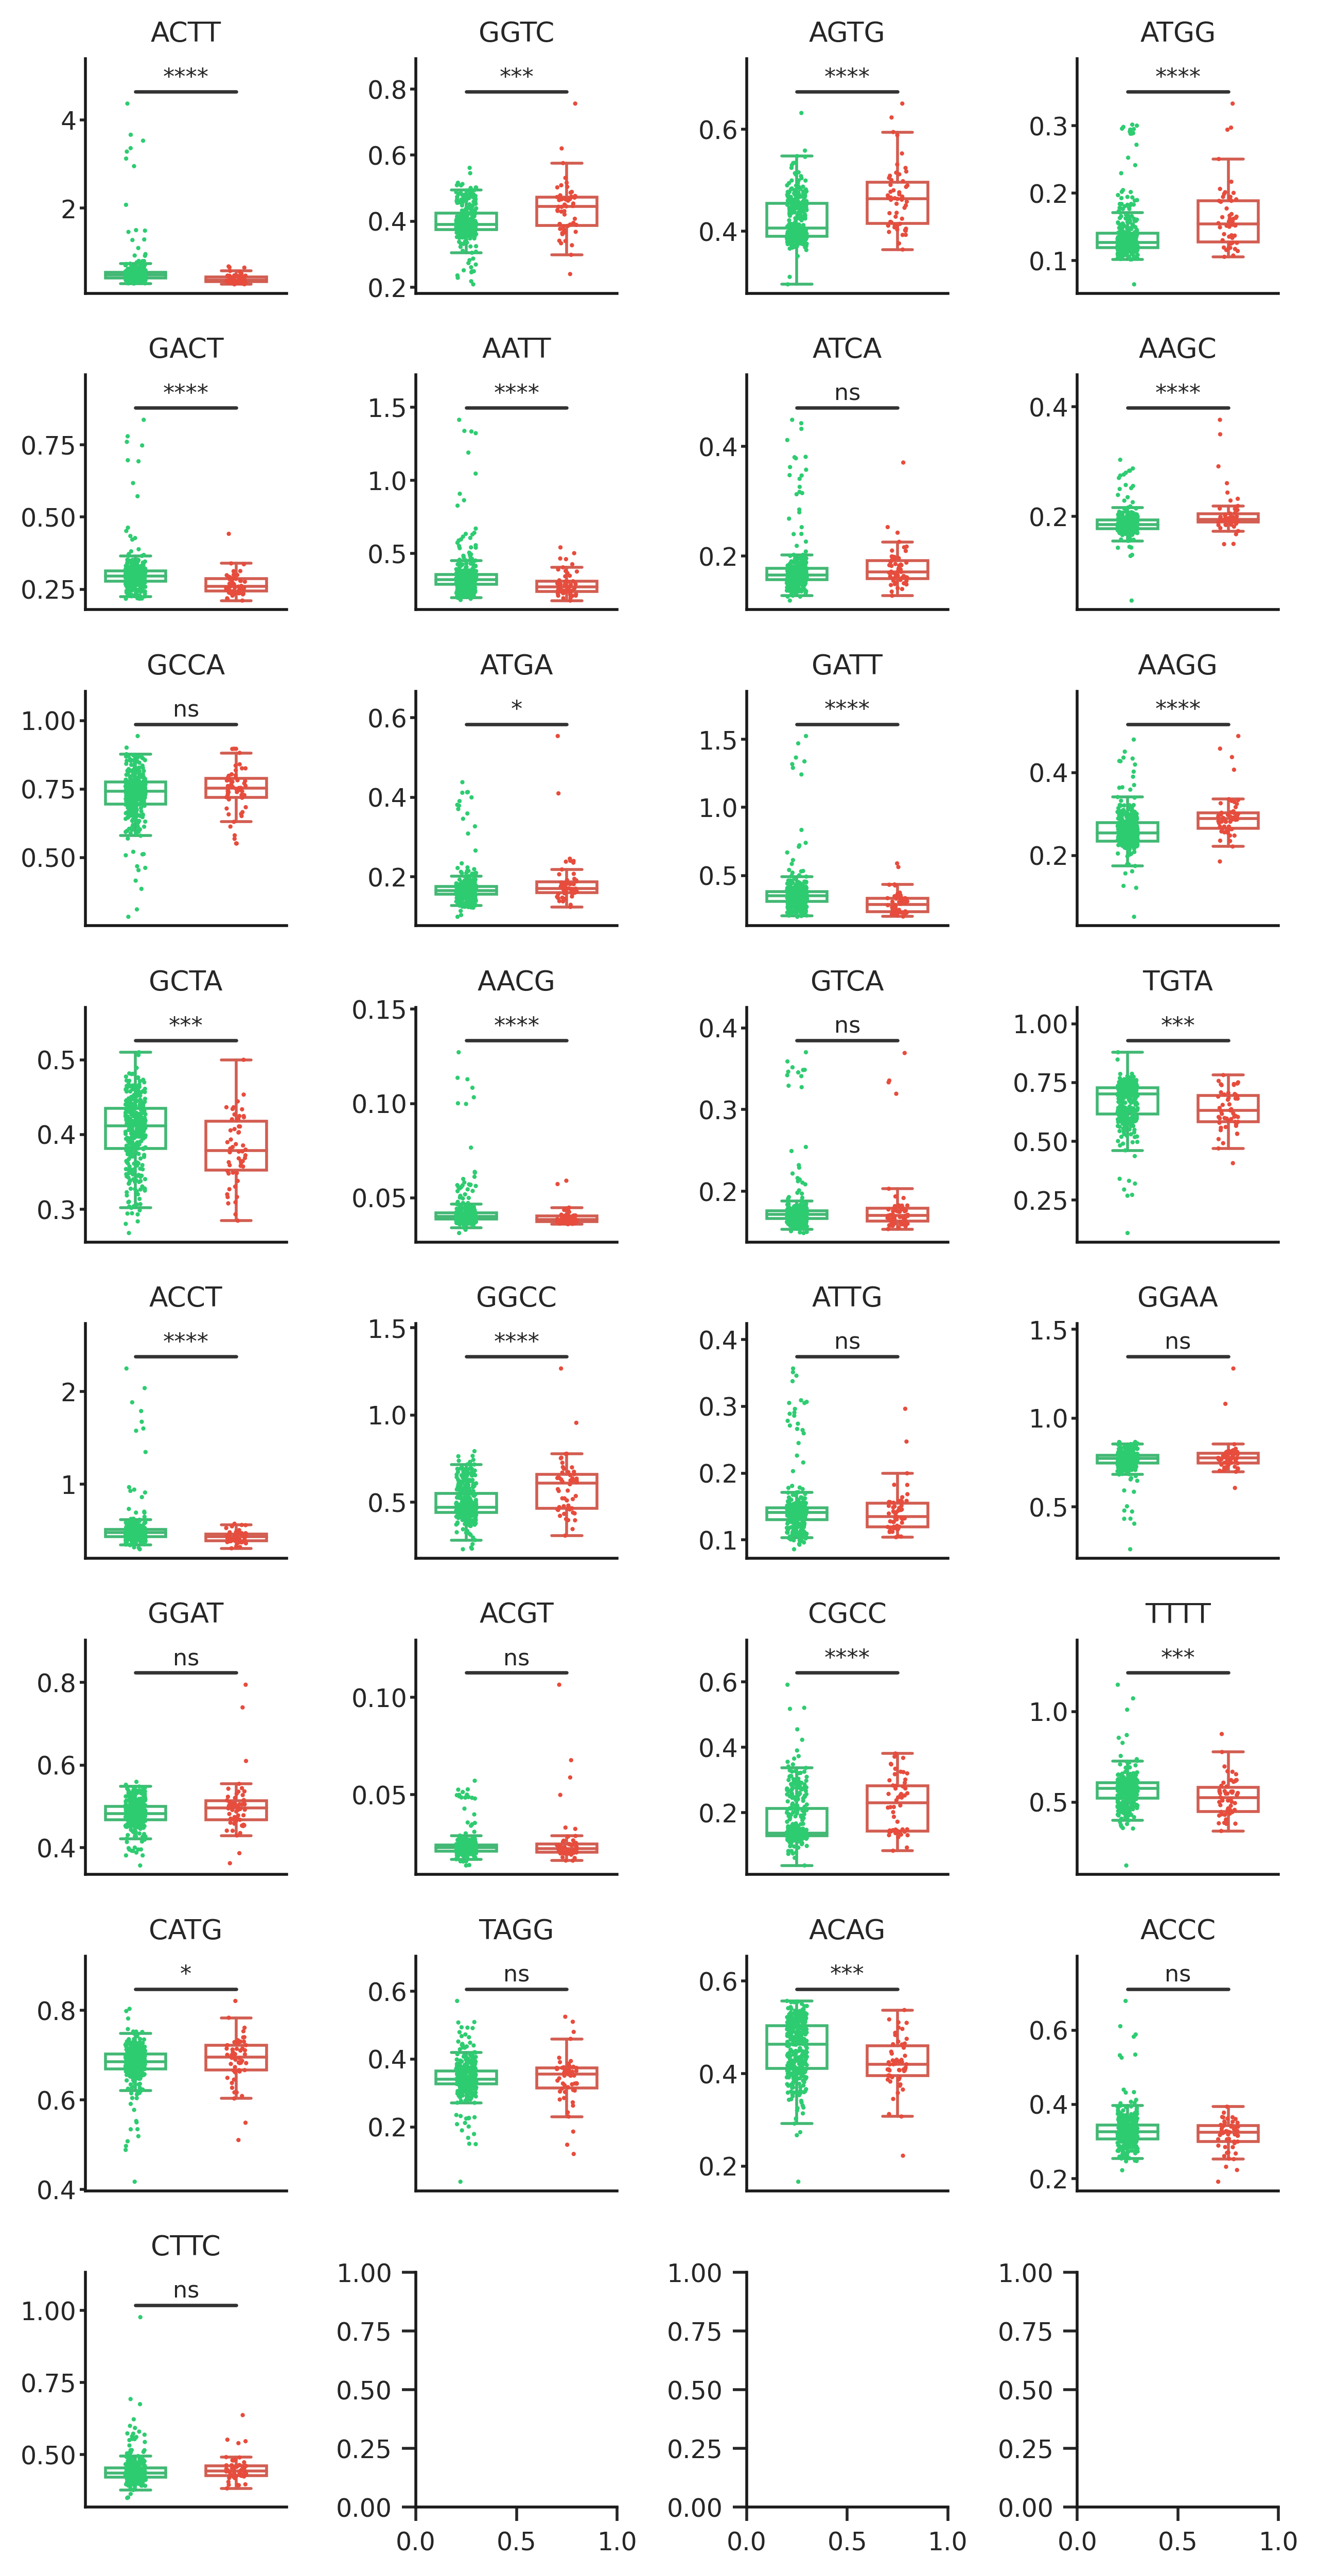

In [27]:
from statannotations.Annotator import Annotator
from scipy.stats import mannwhitneyu

# fig, axs = plt.subplots(1,len(i_feats_name), figsize=(6.8,2))
orders = ['Noncritical','Critical']
palette = dict(zip(orders, ['#2ecc71','#e74c3c']))

all_n_feats = {'lab': 15, 'fragl': 7, 'tss': 32, 'motif': 29}

i_n_feats = all_n_feats[fd_types[iidx]]

plot_col_n = 4
    
fig, axs = plt.subplots(int(np.ceil(i_n_feats/plot_col_n)),plot_col_n,
                        figsize=(16.5*centimeter,4*int(np.ceil(i_n_feats/plot_col_n))*centimeter))
axs = axs.ravel()

for iiix in range(i_n_feats):
    plot_param={
        'data':fd_sel_dat,
        'x':'labels',
        'y':fd_feat_names[iiix],
        'order':orders,
        'orient':'v'
    }

    sns.stripplot(**plot_param, ax=axs[iiix],palette=palette,size=1.5)
    axa = sns.boxplot(**plot_param,ax=axs[iiix],palette=palette, showfliers=False, linewidth=1,width=0.6)

    for i,artist in enumerate(axs[iiix].artists):
        # Set the linecolor on the artist to the facecolor, and set the facecolor to None
        col = artist.get_facecolor()
        artist.set_edgecolor(col)
        artist.set_facecolor('None')

        # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same colour as above
        for j in range(i*5,i*5+5):
            line = axa.lines[j]
            line.set_color(col)
            line.set_mfc(col)
            line.set_mec(col)

    noncri_values = fd_sel_dat.loc[fd_sel_dat['labels']=='Noncritical',
                                  fd_feat_names[iiix]].values
    cri_values = fd_sel_dat.loc[fd_sel_dat['labels']=='Critical',
                               fd_feat_names[iiix]].values

    pvalues=[mannwhitneyu(noncri_values, cri_values, alternative="two-sided").pvalue]

    formatted_pvalues = [f"p={p:.2e}" for p in pvalues]

    anno_pairs= [(orders[0], orders[1])]
    annot = Annotator(axa, pairs=anno_pairs, **plot_param)
    
    annot.set_pvalues(pvalues)
    # annot.reset_configuration()
    # annot.set_custom_annotations(formatted_pvalues)
    annot.configure(verbose=False,line_width=1.2,fontsize=8,loc='inside',line_height=0, text_offset=1)
    annot.annotate()
    
    if fd_feat_names[iiix]=='LDH':
        axa.set_yscale('log') 
        axa.set_ylim((80,3000))
    elif fd_feat_names[iiix]=='Uric_acid': 
        axa.set_ylim((-50,900))
    elif fd_feat_names[iiix]=='α-HBDH': 
        axa.set_ylim((50,700))
    elif fd_feat_names[iiix]=='DBil':
        axa.set_yscale('log') 
        axa.set_ylim((-100,300))
    # else:
    #     axa.set_ylim((-0,650))
    
    if fd_iidx_type == 'tss':
        
        axa.set_title(tss_gene_df.loc[tss_gene_df['tss']==fd_feat_names[iiix], 'gene'].values[0])
    
    else:
        axa.set_title('UA' \
                   if fd_feat_names[iiix]=='Uric_acid' else fd_feat_names[iiix])
    axa.set_xlabel(None)
    axa.set_ylabel(None)
    axa.set_xticks([])
    axa.tick_params(direction='out', length=2, pad=1, width=1)

    # axa.set_xticklabels(axa.get_xticklabels(),rotation=30, ha='right')
    sns.despine()
plt.tight_layout()
plt.savefig("results_plt/feat_all_important_dist_{}.pdf".format(fd_types[iidx]), dpi=400, bbox_inches='tight',format='pdf')

## Feature SHAP cumsum

/zfssz2/ST_MCHRI/BIGDATA/USER/baiyong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


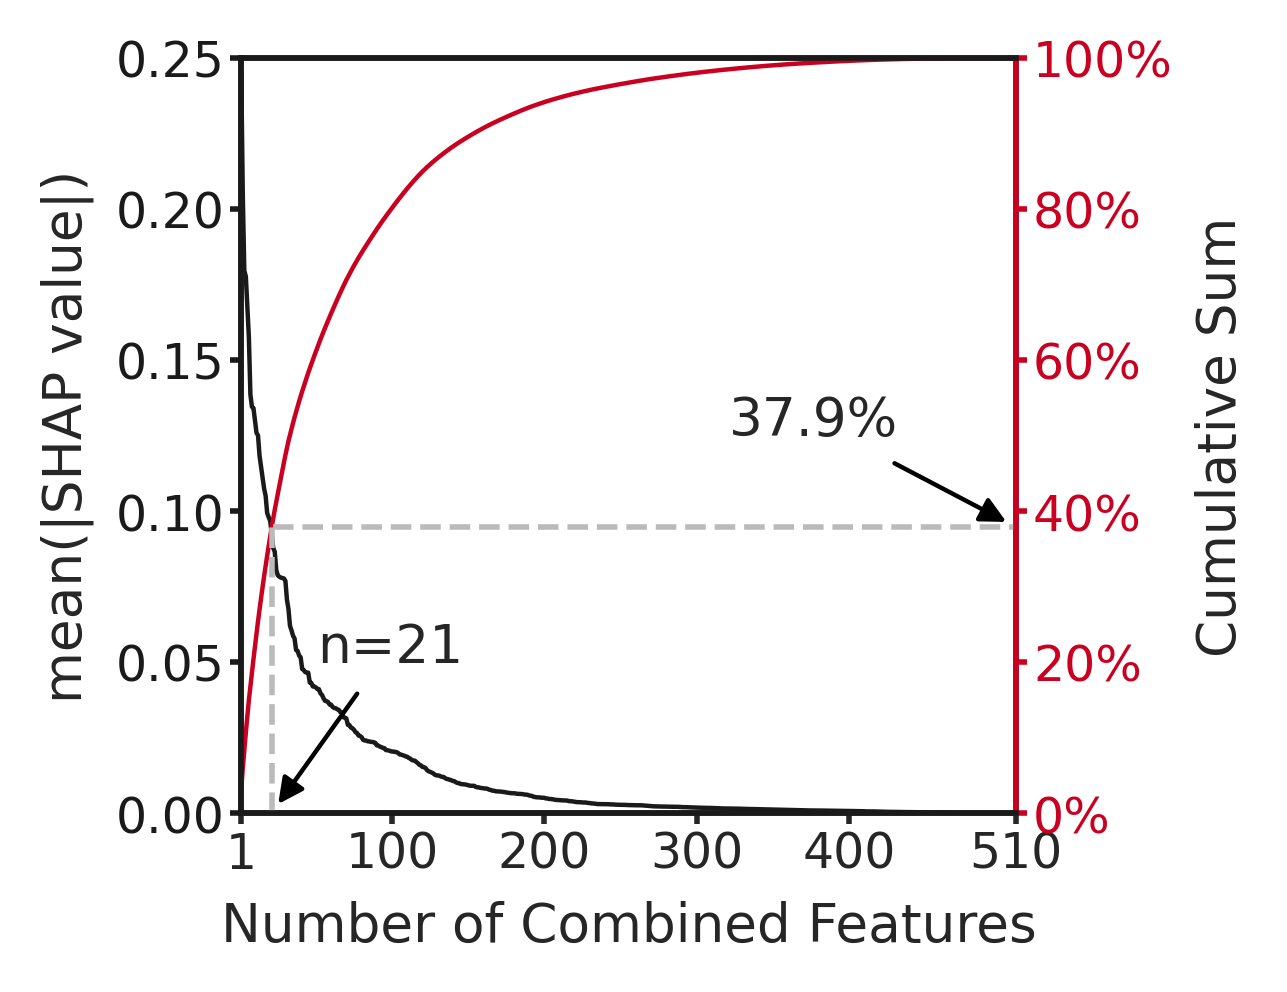

In [21]:
i_feat_type='m2model'
m2model_all_shap = load_feat_importance_shap(i_feat_type, return_all=True)

mean_shaps = m2model_all_shap['feat_shap_mean'].values
mean_shap_cumsum = np.cumsum(mean_shaps)/mean_shaps.sum()

fig, ax1 = plt.subplots(1,1,figsize=(2.5,2.5))

ax1.plot(range(m2model_all_shap.shape[0]), m2model_all_shap['feat_shap_mean'].values, c='k', lw = 0.8)
ax1.tick_params(axis='y', colors='k')
ax1.set_ylim(0,0.25)
ax1.set_xlim(0,509)

ax2 = ax1.twinx()
ax2.plot(range(m2model_all_shap.shape[0]), mean_shap_cumsum, c='#ca0020', lw = 0.8)
ax2.tick_params(axis='y', colors='#ca0020')
ax2.spines['right'].set_color('#ca0020')
ax2.spines['left'].set_color('k')
ax2.set_ylim(0,1)
ax2.axvline(x = 20,ymax=mean_shap_cumsum[20], ls='--', lw=1, c='#bababa')
ax2.axhline(y=mean_shap_cumsum[20],xmin=21/510, ls='--', lw=1, c='#bababa')
# ax2.plot([20, 50], [0, 0.05], color='k', linestyle='-', lw=0.5)
# ax2.text(25, 0.05, 'n=21', fontsize=8)
ax2.annotate("n=21", xy=(20, 0), xytext=(50, 0.2), arrowprops=dict(arrowstyle="-|>",color='black'))

ax2.annotate("{:.1f}%".format(mean_shap_cumsum[20]*100), 
             xy=(509, mean_shap_cumsum[20]), xytext=(320, 0.50), arrowprops=dict(arrowstyle="-|>",color='black'))

ax1.set_xlabel('Number of Combined Features')
ax1.set_ylabel('mean(|SHAP value|)')
# ax1.yaxis.label.set_color('red')
ax2.set_ylabel('Cumulative Sum')
# ax2.yaxis.label.set_color('blue')

steps = 100
x_tick = [0] + list(range(steps-1, mean_shap_cumsum.shape[0],steps)) 
x_tick[-1] = mean_shap_cumsum.shape[0]-1
ax2.set_xticks(x_tick)
xtick_lab = np.array(x_tick)+1
ax2.set_xticklabels(xtick_lab) 

ax2.set_yticklabels(['{}%'.format(int(x*100)) for x in ax2.get_yticks()]) 

ax1.tick_params(direction='out', length=2, pad=1, width=1)
ax2.tick_params(direction='out', length=2, pad=1, width=1)

plt.savefig("results_plt/feat_importance_cumsum_{}_n{}.pdf".format(i_feat_type, m2model_all_shap.shape[0]), dpi=400, bbox_inches='tight')

In [29]:
mean_shap_cumsum[:21]

array([0.03240392, 0.05950969, 0.08326844, 0.10677694, 0.12892508,
       0.14976472, 0.16809848, 0.1858948 , 0.20363803, 0.22084014,
       0.23749786, 0.25404017, 0.26969217, 0.2848602 , 0.29956362,
       0.31377905, 0.32767937, 0.34082654, 0.35378804, 0.36658476,
       0.37881393])

## Feature Contribution in M2Model

In [9]:

max_feat_idx_ap = {'lab': 14, 'fragl': 6, 'tss': 31, 'motif': 28, 'm2model': 20}
i_feat_type = 'm2model'

i_re_perf_fname = os.path.join(model_re_root_dir, '{}/32_fl_entire_feat_retrain-auc.pkl'.format(i_feat_type))
with open(i_re_perf_fname, 'rb') as f:
    perf_feats = pickle.load(f)
    
# i_re = perf_feats[0]
preds_df = []
for n_idx, i_re in enumerate(perf_feats): 
    # https://github.com/slundberg/shap/issues/632
    shap_values_t = i_re[3] # shap values)
    preds_df.append(pd.concat([i_re[2], pd.DataFrame(shap_values_t, columns=i_re[0].feature_name())], axis=1))
all_tmp_preds_df = pd.concat(preds_df)
f_pred_df = all_tmp_preds_df.groupby('ind').mean()
f_pred_df.reset_index(level=0, inplace=True)
tmp=f_pred_df.copy()
f_pred_df['sum_abs_shap_lab']=tmp.iloc[:,3:62+3].abs().sum(1)/tmp.iloc[:,3:].abs().sum(1)
f_pred_df['sum_abs_shap_fragl']=tmp.iloc[:,62+3:62+3+15].abs().sum(1)/tmp.iloc[:,3:].abs().sum(1)
f_pred_df['sum_abs_shap_tss']=tmp.iloc[:,62+3+15:62+3+15+177].abs().sum(1)/tmp.iloc[:,3:].abs().sum(1)
f_pred_df['sum_abs_shap_motif']=tmp.iloc[:,62+3+15+177:].abs().sum(1)/tmp.iloc[:,3:].abs().sum(1)


pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


In [ ]:
f_pred_df.head()

In [11]:
m2model_feats = load_feat_importance_shap('m2model')['feat_name'].values
featnames = load_all_feats_name()
f_type=[]
for f in m2model_feats:
    for iiidx, t in enumerate('lab,fragl,tss,motif'.split(',')):
        if f in featnames[t]:
            f_type.append(t)
            break

f_type = np.array(f_type)

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [12]:
# lab contribution
print("lab contrib:", np.mean(f_pred_df['sum_abs_shap_lab'].values),
      np.median(f_pred_df['sum_abs_shap_lab'].values),
      f_pred_df['sum_abs_shap_lab'].values.std(),
      np.percentile(f_pred_df['sum_abs_shap_lab'].values, [2.5, 97.5]))
# fragl contribution
print('fragl contrib:', np.mean(f_pred_df['sum_abs_shap_fragl'].values),
      np.median(f_pred_df['sum_abs_shap_fragl'].values),
      f_pred_df['sum_abs_shap_fragl'].values.std(),
      np.percentile(f_pred_df['sum_abs_shap_fragl'].values, [2.5, 97.5]))
# tss contribution
print('tss contrib:', np.mean(f_pred_df['sum_abs_shap_tss'].values),
      np.median(f_pred_df['sum_abs_shap_tss'].values),
      f_pred_df['sum_abs_shap_tss'].values.std(),
      np.percentile(f_pred_df['sum_abs_shap_tss'].values, [2.5, 97.5]))
# motif contribution
print('motif contrib:', np.mean(f_pred_df['sum_abs_shap_motif'].values),
      np.median(f_pred_df['sum_abs_shap_motif'].values),
      f_pred_df['sum_abs_shap_motif'].values.std(),
      np.percentile(f_pred_df['sum_abs_shap_motif'].values, [2.5, 97.5]))

lab contrib: 0.21333522876337263 0.19041480656790796 0.06281687734682263 [0.14693285 0.38403276]
fragl contrib: 0.0072183392720210305 0.006239933992508705 0.0035157856430551217 [0.0030922  0.01729475]
tss contrib: 0.7203852407476364 0.7403290484395092 0.061631028277310033 [0.56034531 0.79290888]
motif contrib: 0.05906119121696992 0.05720413183288916 0.012726018918481814 [0.0384756  0.08796864]


In [13]:
# tss + lab contribution
tsslab_cont = f_pred_df['sum_abs_shap_lab'] + f_pred_df['sum_abs_shap_tss']
print('tss + lab contrib:', np.mean(tsslab_cont),
      np.median(tsslab_cont.values),
      np.std(tsslab_cont),
      np.percentile(tsslab_cont, [2.5, 97.5]))

tss + lab contrib: 0.9337204695110087 0.9367315728326333 0.01448915913686004 [0.89993877 0.95655791]


### Plot Contribution

/zfssz2/ST_MCHRI/BIGDATA/USER/baiyong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator


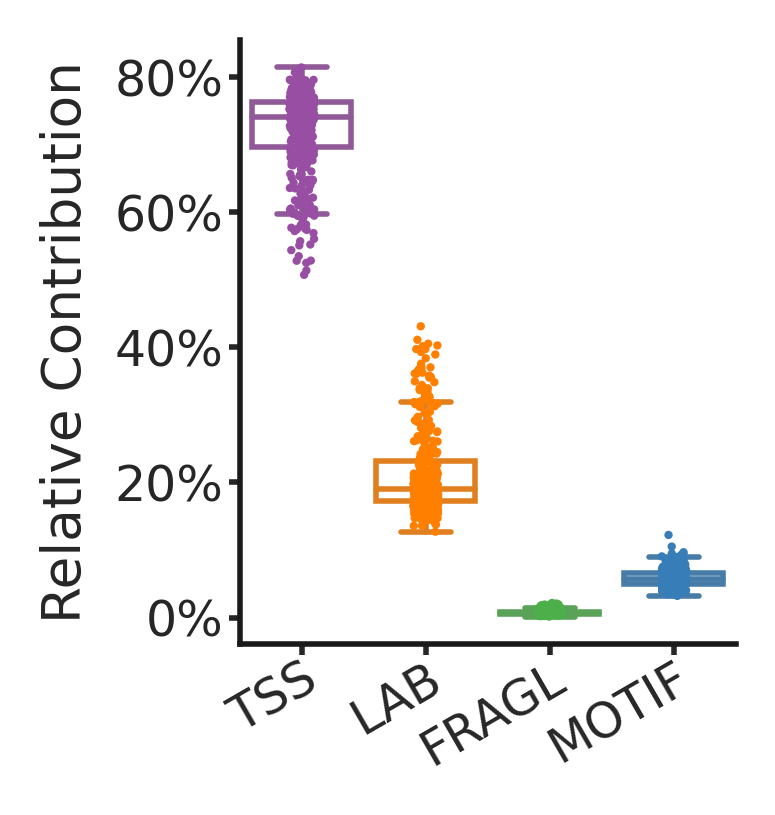

In [35]:
from statannotations.Annotator import Annotator
from scipy.stats import mannwhitneyu

#
# https://stats.stackexchange.com/questions/501039/can-i-scale-and-then-interpret-shap-values-as-percent-contribution-to-the-predic
#
ds_contrib_df = pd.concat([pd.DataFrame({'feats':['LAB']*f_pred_df.shape[0], 'contrib':f_pred_df['sum_abs_shap_lab'].values}),
                          pd.DataFrame({'feats':['FRAGL']*f_pred_df.shape[0], 'contrib':f_pred_df['sum_abs_shap_fragl'].values}),
                          pd.DataFrame({'feats':['TSS']*f_pred_df.shape[0], 'contrib':f_pred_df['sum_abs_shap_tss'].values}),
                          pd.DataFrame({'feats':['MOTIF']*f_pred_df.shape[0], 'contrib':f_pred_df['sum_abs_shap_motif'].values})])

orders = ['TSS','LAB', 'FRAGL', 'MOTIF']

palette = {'TSS':'#984ea3','LAB':'#ff7f00', 'FRAGL':'#4daf4a', 'MOTIF':'#377eb8'}

fig, axs = plt.subplots(1,1, figsize=(1.6,2))

plot_param={
    'data':ds_contrib_df,
    'x':'feats',
    'y':'contrib',
    'order':orders,
    'orient':'v'
}

sns.stripplot(**plot_param, ax=axs,palette=palette,size=1.5)
axa = sns.boxplot(**plot_param,ax=axs,palette=palette, showfliers=False, linewidth=1,width=0.8)
for i,artist in enumerate(axa.artists):
    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
    col = artist.get_facecolor()
    artist.set_edgecolor(col)
    artist.set_facecolor('None')

    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for j in range(i*5,i*5+5):
        line = axa.lines[j]
        line.set_color(col)
        line.set_mfc(col)
        line.set_mec(col)

# tss_values = ds_contrib_df.loc[ds_contrib_df['feats']==orders[0],'contrib'].values
# lab_values = ds_contrib_df.loc[ds_contrib_df['feats']==orders[1],'contrib'].values
# fragl_values = ds_contrib_df.loc[ds_contrib_df['feats']==orders[2],'contrib'].values
# motif_values = ds_contrib_df.loc[ds_contrib_df['feats']==orders[3],'contrib'].values

# pvalues = [
#     mannwhitneyu(tss_values, lab_values, alternative="two-sided").pvalue,
#     mannwhitneyu(tss_values, fragl_values, alternative="two-sided").pvalue,
#     mannwhitneyu(tss_values, motif_values, alternative="two-sided").pvalue
# ]
# formatted_pvalues = [f"p={p:.2e}" for p in pvalues]

# anno_pairs= [(orders[0], orders[1]),(orders[0], orders[2]),(orders[0], orders[3])]
# annot = Annotator(axa, pairs=anno_pairs, **plot_param)
# annot.reset_configuration()
# annot.set_custom_annotations(formatted_pvalues)
# annot.configure(verbose=False,line_width=1.2,fontsize=8,loc='inside',line_height=0, text_offset=1)
# annot.annotate(line_offset=0.01)

axa.set_xlabel('')
axa.set_yticklabels(['{}%'.format(int(x*100)) for x in axa.get_yticks()]) 
axa.set_ylabel('Relative Contribution')
sns.despine()
xticklabels = axa.set_xticklabels(axa.get_xticklabels(),rotation=30, ha='right',rotation_mode="anchor")
for i, xticklabel in enumerate(xticklabels):
    xticklabel.set_y(xticklabel.get_position()[1] +  0.01)
axa.tick_params(direction='out', length=2, pad=1, width=1)

plt.savefig("results_plt/feat_dataset_distribution.pdf", dpi=400, bbox_inches='tight')


### LAB Feature analysis

In [14]:
labs_names = m2model_feats[f_type=='lab']
lab_units = dict(zip(['LDH', 'Uric_acid', 'α-HBDH', 'PA'],['U/L','μmol/L','U/L','mg/L']))
print(labs_names)

# load raw lab data
lab_raw_dat = pd.read_csv(os.path.join(raw_data_dir, '399_labtest_fill.csv'))
imp_feat_data = lab_raw_dat[['ind','new_triage']+labs_names.tolist()].copy()

lab_shap_value = f_pred_df[['ind','new_triage']+labs_names.tolist()].copy()
shap_data_values = imp_feat_data.merge(lab_shap_value, on=['ind','new_triage'])
shap_data_values['labels']=shap_data_values['new_triage'].apply(lambda x: 'Noncritical' if x ==0 else 'Critical')

orders = ['Noncritical','Critical']
palette = dict(zip(orders, ['#2ecc71','#e74c3c']))


['LDH' 'Uric_acid' 'α-HBDH' 'PA']


In [ ]:
shap_data_values

In [ ]:
fp_high_risk_pit = [str(x[2:]) for x in ['PU8811', 'PU1463', 'PU8151', 'PU6778', 'PU7436', 'PU8494', 'PU8354']]
shap_data_values[shap_data_values['ind'].str.slice(start=5,stop=9).isin(fp_high_risk_pit)]

In [17]:
shap_data_values[shap_data_values['ind'].str.slice(start=5,stop=9)=='8354']

ind  new_triage  LDH_x  Uric_acid_x  α-HBDH_x   PA_x  \
279  DP9248354_D0306-1         0.0  296.0         86.6     225.0  146.8   

        LDH_y  Uric_acid_y  α-HBDH_y      PA_y       labels  
279  0.794902     0.504235  0.322705  0.379012  Noncritical

In [22]:
# get the LDH value w.s.t shap value
np.min(shap_data_values.loc[shap_data_values['LDH_y']>0, 'LDH_x'].values)


233.0

In [23]:
# get the α-HBDH value w.s.t shap value
np.min(shap_data_values.loc[shap_data_values['α-HBDH_y']>0, 'α-HBDH_x'].values)

182.0

In [26]:
# get the Uric_acid value w.s.t shap value
np.max(shap_data_values.loc[shap_data_values['Uric_acid_y']>0, 'Uric_acid_x'].values)

196.6

In [27]:
# get the α-HBDH value w.s.t shap value
np.max(shap_data_values.loc[shap_data_values['PA_y']>0, 'PA_x'].values)

274.0

#### Analysis based on SHAP

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


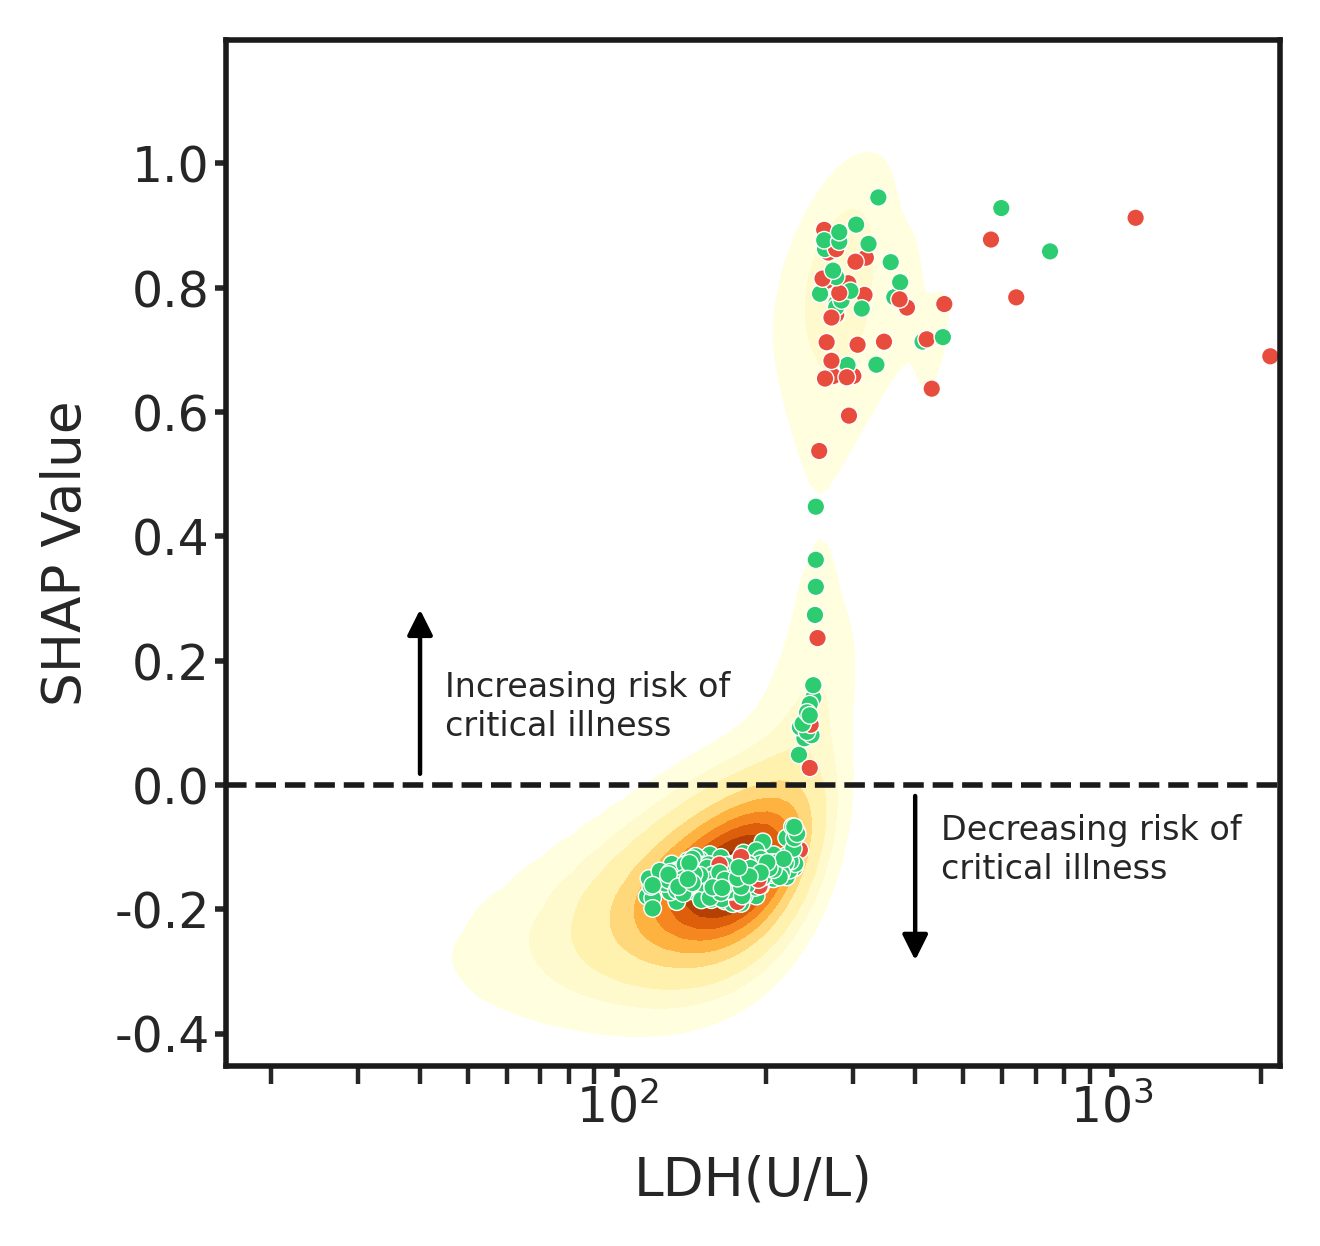

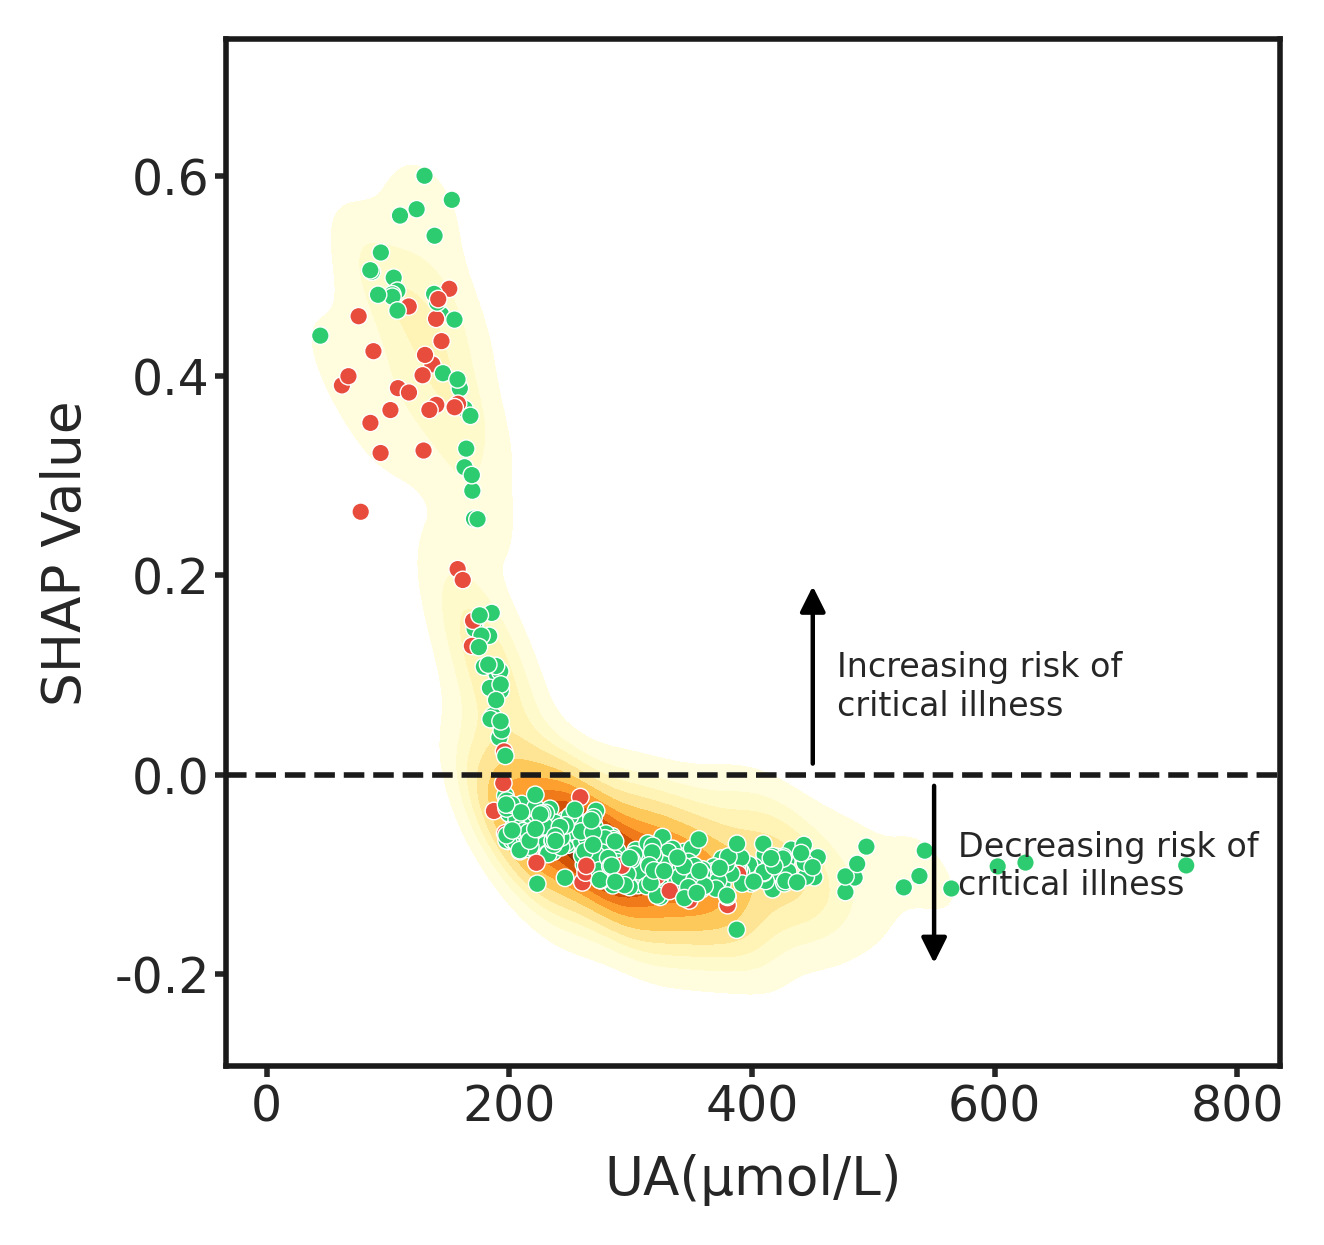

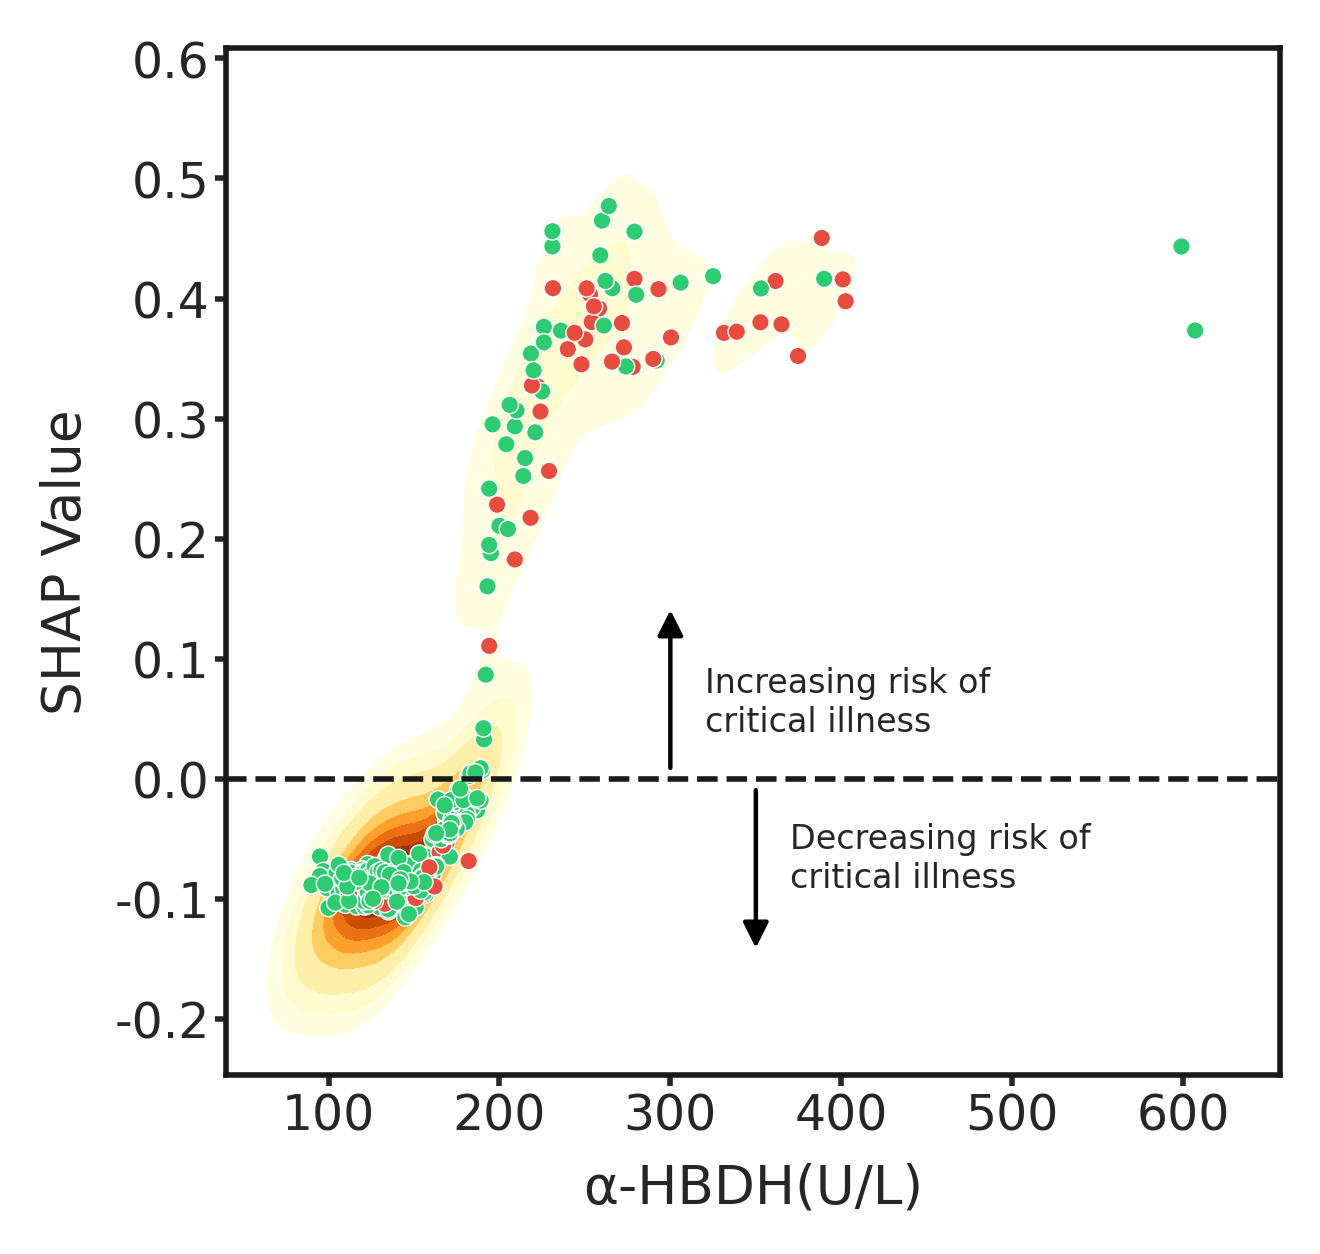

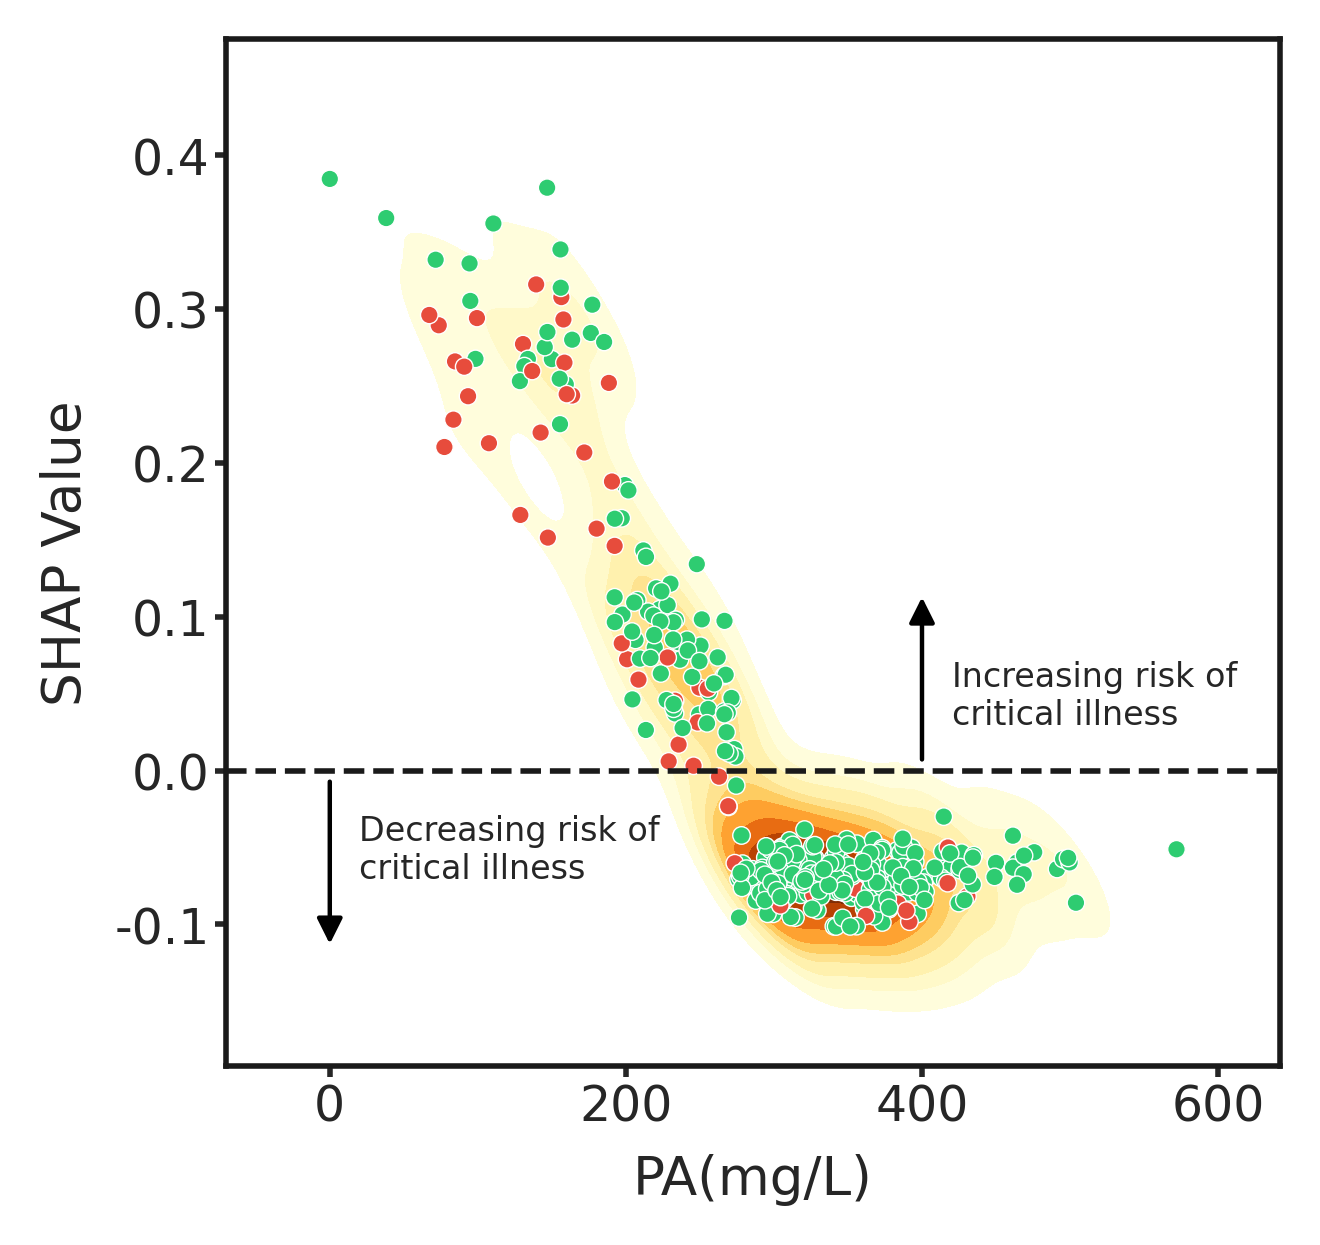

In [38]:
# plot
pid='8354'
for i_lab_name in labs_names:
    
    fig, ax1 = plt.subplots(1,1,figsize=(3.4,3.4))
    sns.kdeplot(x=shap_data_values['{}_x'.format(i_lab_name)], 
                y=shap_data_values['{}_y'.format(i_lab_name)], cmap="YlOrBr", shade=True, bw_adjust=.7,ax=ax1)
    sns.scatterplot(data=shap_data_values, x='{}_x'.format(i_lab_name), 
                    y='{}_y'.format(i_lab_name),edgecolors=None,
                    hue="labels",palette=palette, ax=ax1,s=10)
    
    fp_high_risk_exam = shap_data_values[shap_data_values['ind'].str.slice(start=5,stop=9)==pid]
    
    # ax1.annotate("PU{}".format(pid), 
    #              xy=(fp_high_risk_exam['{}_x'.format(i_lab_name)], fp_high_risk_exam['{}_y'.format(i_lab_name)]),
    #              xytext=(fp_high_risk_exam['{}_x'.format(i_lab_name)]-20, fp_high_risk_exam['{}_y'.format(i_lab_name)]),
    #              arrowprops=dict(arrowstyle="-|>",color='black'))
    
    ax1.axhline(y=0, ls='--', lw=1,c='k')
    
    if i_lab_name == 'LDH':
        ax1.set_xscale('log')
    ax1.set_ylabel('SHAP Value')
    
    if i_lab_name == 'Uric_acid':
        ax1.set_xlabel('UA({})'.format(lab_units[i_lab_name]))
    else:
        ax1.set_xlabel(i_lab_name+'({})'.format(lab_units[i_lab_name]))
        
    # 
    if i_lab_name == 'LDH':
        ax1.annotate("", xy=(40, 0), xytext=(40, 0.3), arrowprops=dict(arrowstyle="<|-",color='black'))
        ax1.annotate("", xy=(400, 0), xytext=(400, -0.3), arrowprops=dict(arrowstyle="<|-",color='black'))
        ax1.text(45, 0.08, 'Increasing risk of\ncritical illness', fontsize=6)
        ax1.text(450, -0.15, 'Decreasing risk of\ncritical illness', fontsize=6)
    elif i_lab_name == 'Uric_acid':
        ax1.annotate("", xy=(450, 0), xytext=(450, 0.2), arrowprops=dict(arrowstyle="<|-",color='black'))
        ax1.annotate("", xy=(550, 0), xytext=(550, -0.2), arrowprops=dict(arrowstyle="<|-",color='black'))
        ax1.text(470, 0.06, 'Increasing risk of\ncritical illness', fontsize=6)
        ax1.text(570, -0.12, 'Decreasing risk of\ncritical illness', fontsize=6)
    elif i_lab_name == 'α-HBDH':
        ax1.annotate("", xy=(300, 0), xytext=(300, 0.15), arrowprops=dict(arrowstyle="<|-",color='black'))
        ax1.annotate("", xy=(350, 0), xytext=(350, -0.15), arrowprops=dict(arrowstyle="<|-",color='black'))
        ax1.text(320, 0.04, 'Increasing risk of\ncritical illness', fontsize=6)
        ax1.text(370, -0.09, 'Decreasing risk of\ncritical illness', fontsize=6)
    else:
        ax1.annotate("", xy=(400, 0), xytext=(400, 0.12), arrowprops=dict(arrowstyle="<|-",color='black'))
        ax1.annotate("", xy=(0, 0), xytext=(0, -0.12), arrowprops=dict(arrowstyle="<|-",color='black'))
        ax1.text(420, 0.03, 'Increasing risk of\ncritical illness', fontsize=6)
        ax1.text(20, -0.07, 'Decreasing risk of\ncritical illness', fontsize=6)
    
    ax1.tick_params(direction='out', length=2, pad=1, width=1)
    
    ax1.get_legend().remove()
    plt.savefig("results_plt/feat_shap_values_{}.pdf".format(i_lab_name), dpi=400, bbox_inches='tight')


#### Analysis Based on Real Values

/zfssz2/ST_MCHRI/BIGDATA/USER/baiyong/anaconda3/lib/python3.6/site-packages/statannotations/Annotator.py:795: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "
/zfssz2/ST_MCHRI/BIGDATA/USER/baiyong/anaconda3/lib/python3.6/site-packages/statannotations/Annotator.py:795: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "
/zfssz2/ST_MCHRI/BIGDATA/USER/baiyong/anaconda3/lib/python3.6/site-packages/statannotations/Annotator.py:795: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "
/zfssz2/ST_MCHRI/BIGDATA/USER/baiyong/anaconda3/lib/python3.6/site-packages/statannotations/Annotator.py:7

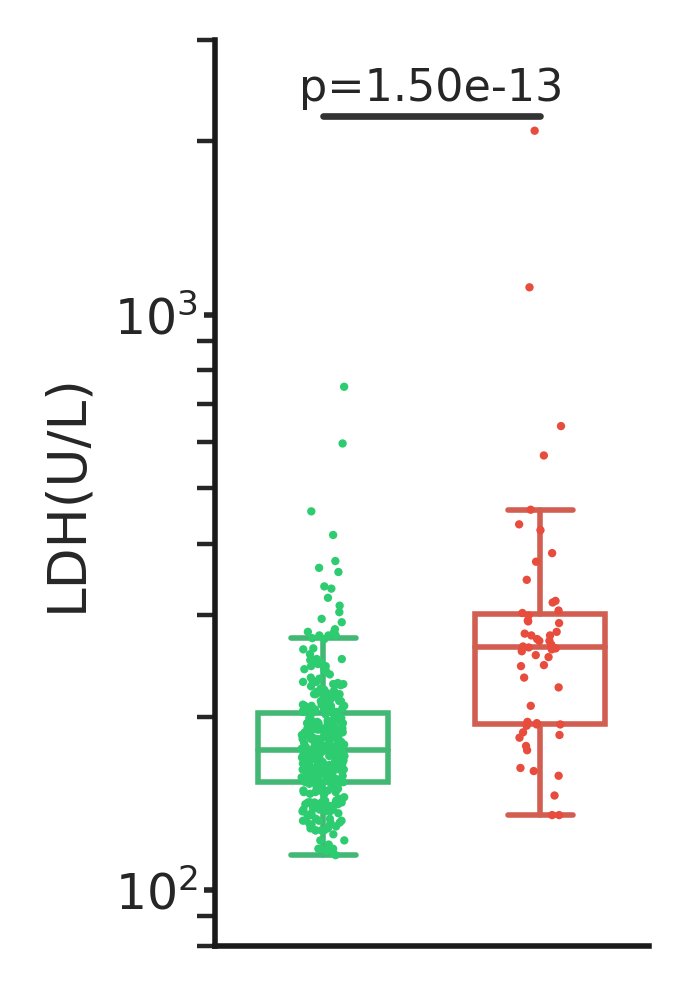

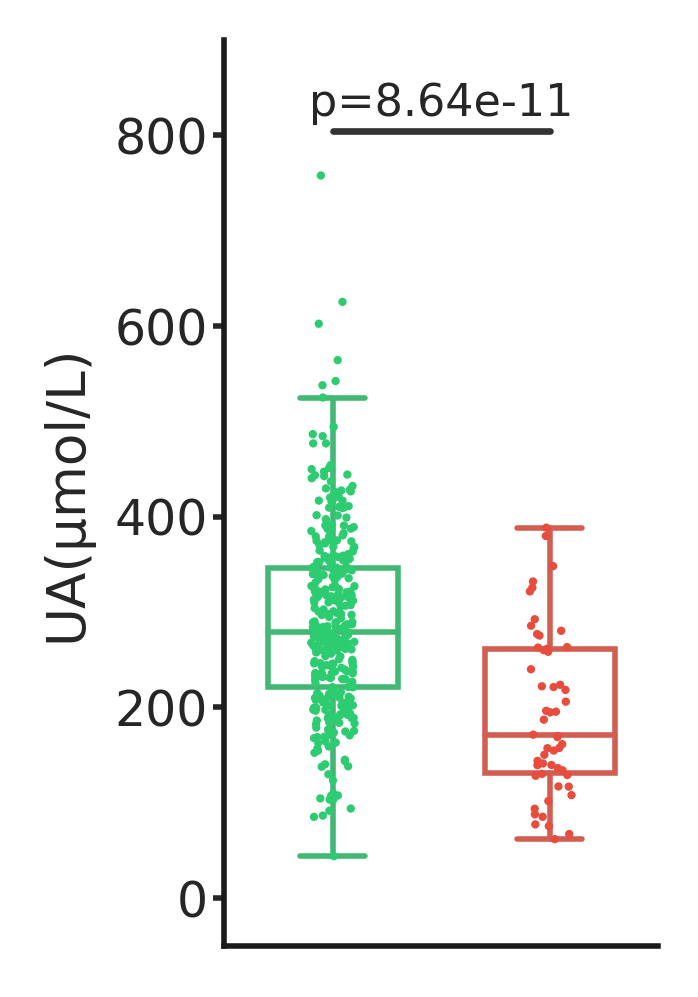

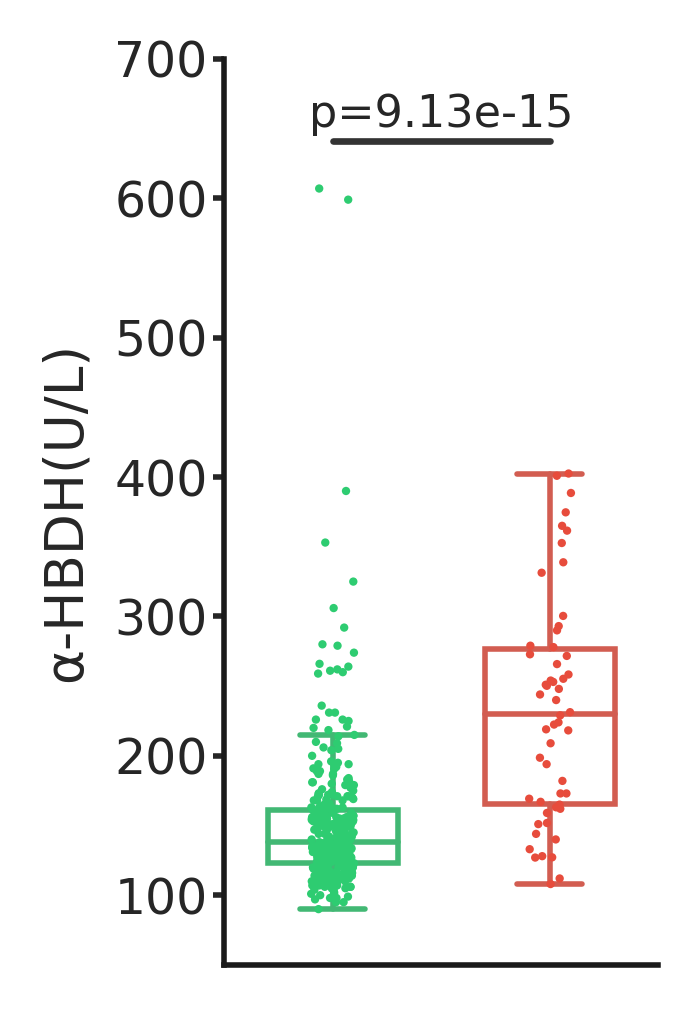

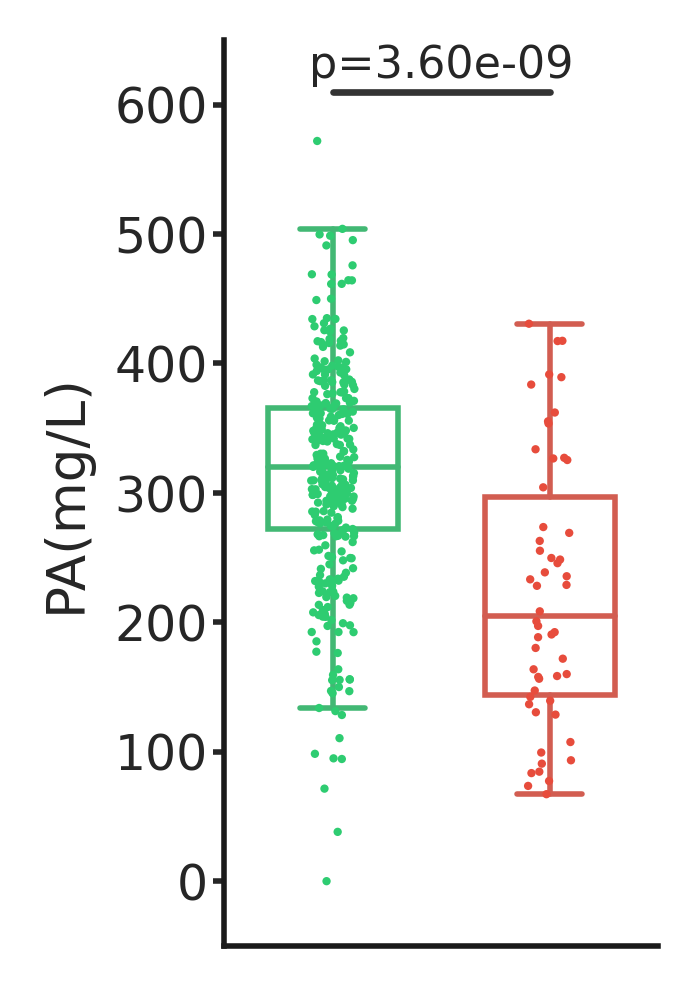

In [39]:
from statannotations.Annotator import Annotator
from scipy.stats import mannwhitneyu

# fig, axs = plt.subplots(1,len(i_feats_name), figsize=(6.8,2))
orders = ['Noncritical','Critical']
palette = dict(zip(orders, ['#2ecc71','#e74c3c']))

for ix in range(len(labs_names)):
    
    fig, axs = plt.subplots(1,1,figsize=(1.4,3))

    plot_param={
        'data':shap_data_values,
        'x':'labels',
        'y':labs_names[ix]+'_x',
        'order':orders,
        'orient':'v'
    }

    sns.stripplot(**plot_param, ax=axs,palette=palette,size=1.5)
    axa = sns.boxplot(**plot_param,ax=axs,palette=palette, showfliers=False, linewidth=1,width=0.6)

    for i,artist in enumerate(axs.artists):
        # Set the linecolor on the artist to the facecolor, and set the facecolor to None
        col = artist.get_facecolor()
        artist.set_edgecolor(col)
        artist.set_facecolor('None')

        # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same colour as above
        for j in range(i*5,i*5+5):
            line = axa.lines[j]
            line.set_color(col)
            line.set_mfc(col)
            line.set_mec(col)

    noncri_values = shap_data_values.loc[shap_data_values['labels']=='Noncritical',
                                  labs_names[ix]+'_x'].values
    cri_values = shap_data_values.loc[shap_data_values['labels']=='Critical',
                               labs_names[ix]+'_x'].values

    pvalues=[mannwhitneyu(noncri_values, cri_values, alternative="two-sided").pvalue]

    formatted_pvalues = [f"p={p:.2e}" for p in pvalues]

    anno_pairs= [(orders[0], orders[1])]
    annot = Annotator(axa, pairs=anno_pairs, **plot_param)
    annot.reset_configuration()
    annot.set_custom_annotations(formatted_pvalues)
    annot.configure(verbose=False,line_width=1.2,fontsize=8,loc='inside',line_height=0, text_offset=1)
    annot.annotate()
    if labs_names[ix]=='LDH':
        axa.set_yscale('log') 
        axa.set_ylim((80,3000))
    elif labs_names[ix]=='Uric_acid': 
        axa.set_ylim((-50,900))
    elif labs_names[ix]=='α-HBDH': 
        axa.set_ylim((50,700))
    else:
        axa.set_ylim((-50,650))
    
    axa.set_ylabel('UA('+lab_units[labs_names[ix]]+')' \
                   if labs_names[ix]=='Uric_acid' else labs_names[ix]+'('+lab_units[labs_names[ix]]+')')
    axa.set_xlabel(None)
    axa.set_xticks([])

    # axa.set_xticklabels(axa.get_xticklabels(),rotation=30, ha='right')
    axa.tick_params(direction='out', length=2, pad=1, width=1)
    sns.despine()
    plt.savefig("results_plt/feat_real_dist_{}.pdf".format(labs_names[ix]), dpi=400, bbox_inches='tight')

### TSS Feature analysis

In [93]:
# get TSS features
tss_names = m2model_feats[f_type=='tss']
tss_raw_dat_fname = os.path.join(raw_data_dir, 'tss.fillna.pkl')

with open(tss_raw_dat_fname, 'rb') as f:
    tss_raw_dat = pickle.load(f)[['ind','label']+tss_names.tolist()].copy()
    
tss_raw_dat.rename(columns={"label": "new_triage"}, inplace=True)
tss_raw_dat['labels']=tss_raw_dat['new_triage'].apply(lambda x: 'Noncritical' if x ==0 else 'Critical')

genes = [tss_gene_df.loc[tss_gene_df['tss']==x, 'gene'].values[0] for x in tss_names]
# geness = ['DEFA1' if x == 'DEFA1B,DEFA1' else x for x in genes]
geness=genes
tss_genes_map = dict(zip(tss_names, geness))
tss_raw_dat.rename(columns=tss_genes_map, inplace=True)

In [94]:
tss_shap_value = f_pred_df[['ind','new_triage']+tss_names.tolist()].copy()
tss_shap_value.rename(columns=tss_genes_map, inplace=True)

In [ ]:
tss_shap_value

In [96]:
tss_shap_data_values = tss_raw_dat.merge(tss_shap_value, on=['ind','new_triage'])
tss_shap_data_values['labels']=tss_shap_data_values['new_triage'].apply(lambda x: 'Noncritical' if x ==0 else 'Critical')

orders = ['Critical', 'Noncritical']
palette = dict(zip(orders, ['#e74c3c','#2ecc71']))

In [ ]:
tss_shap_data_values

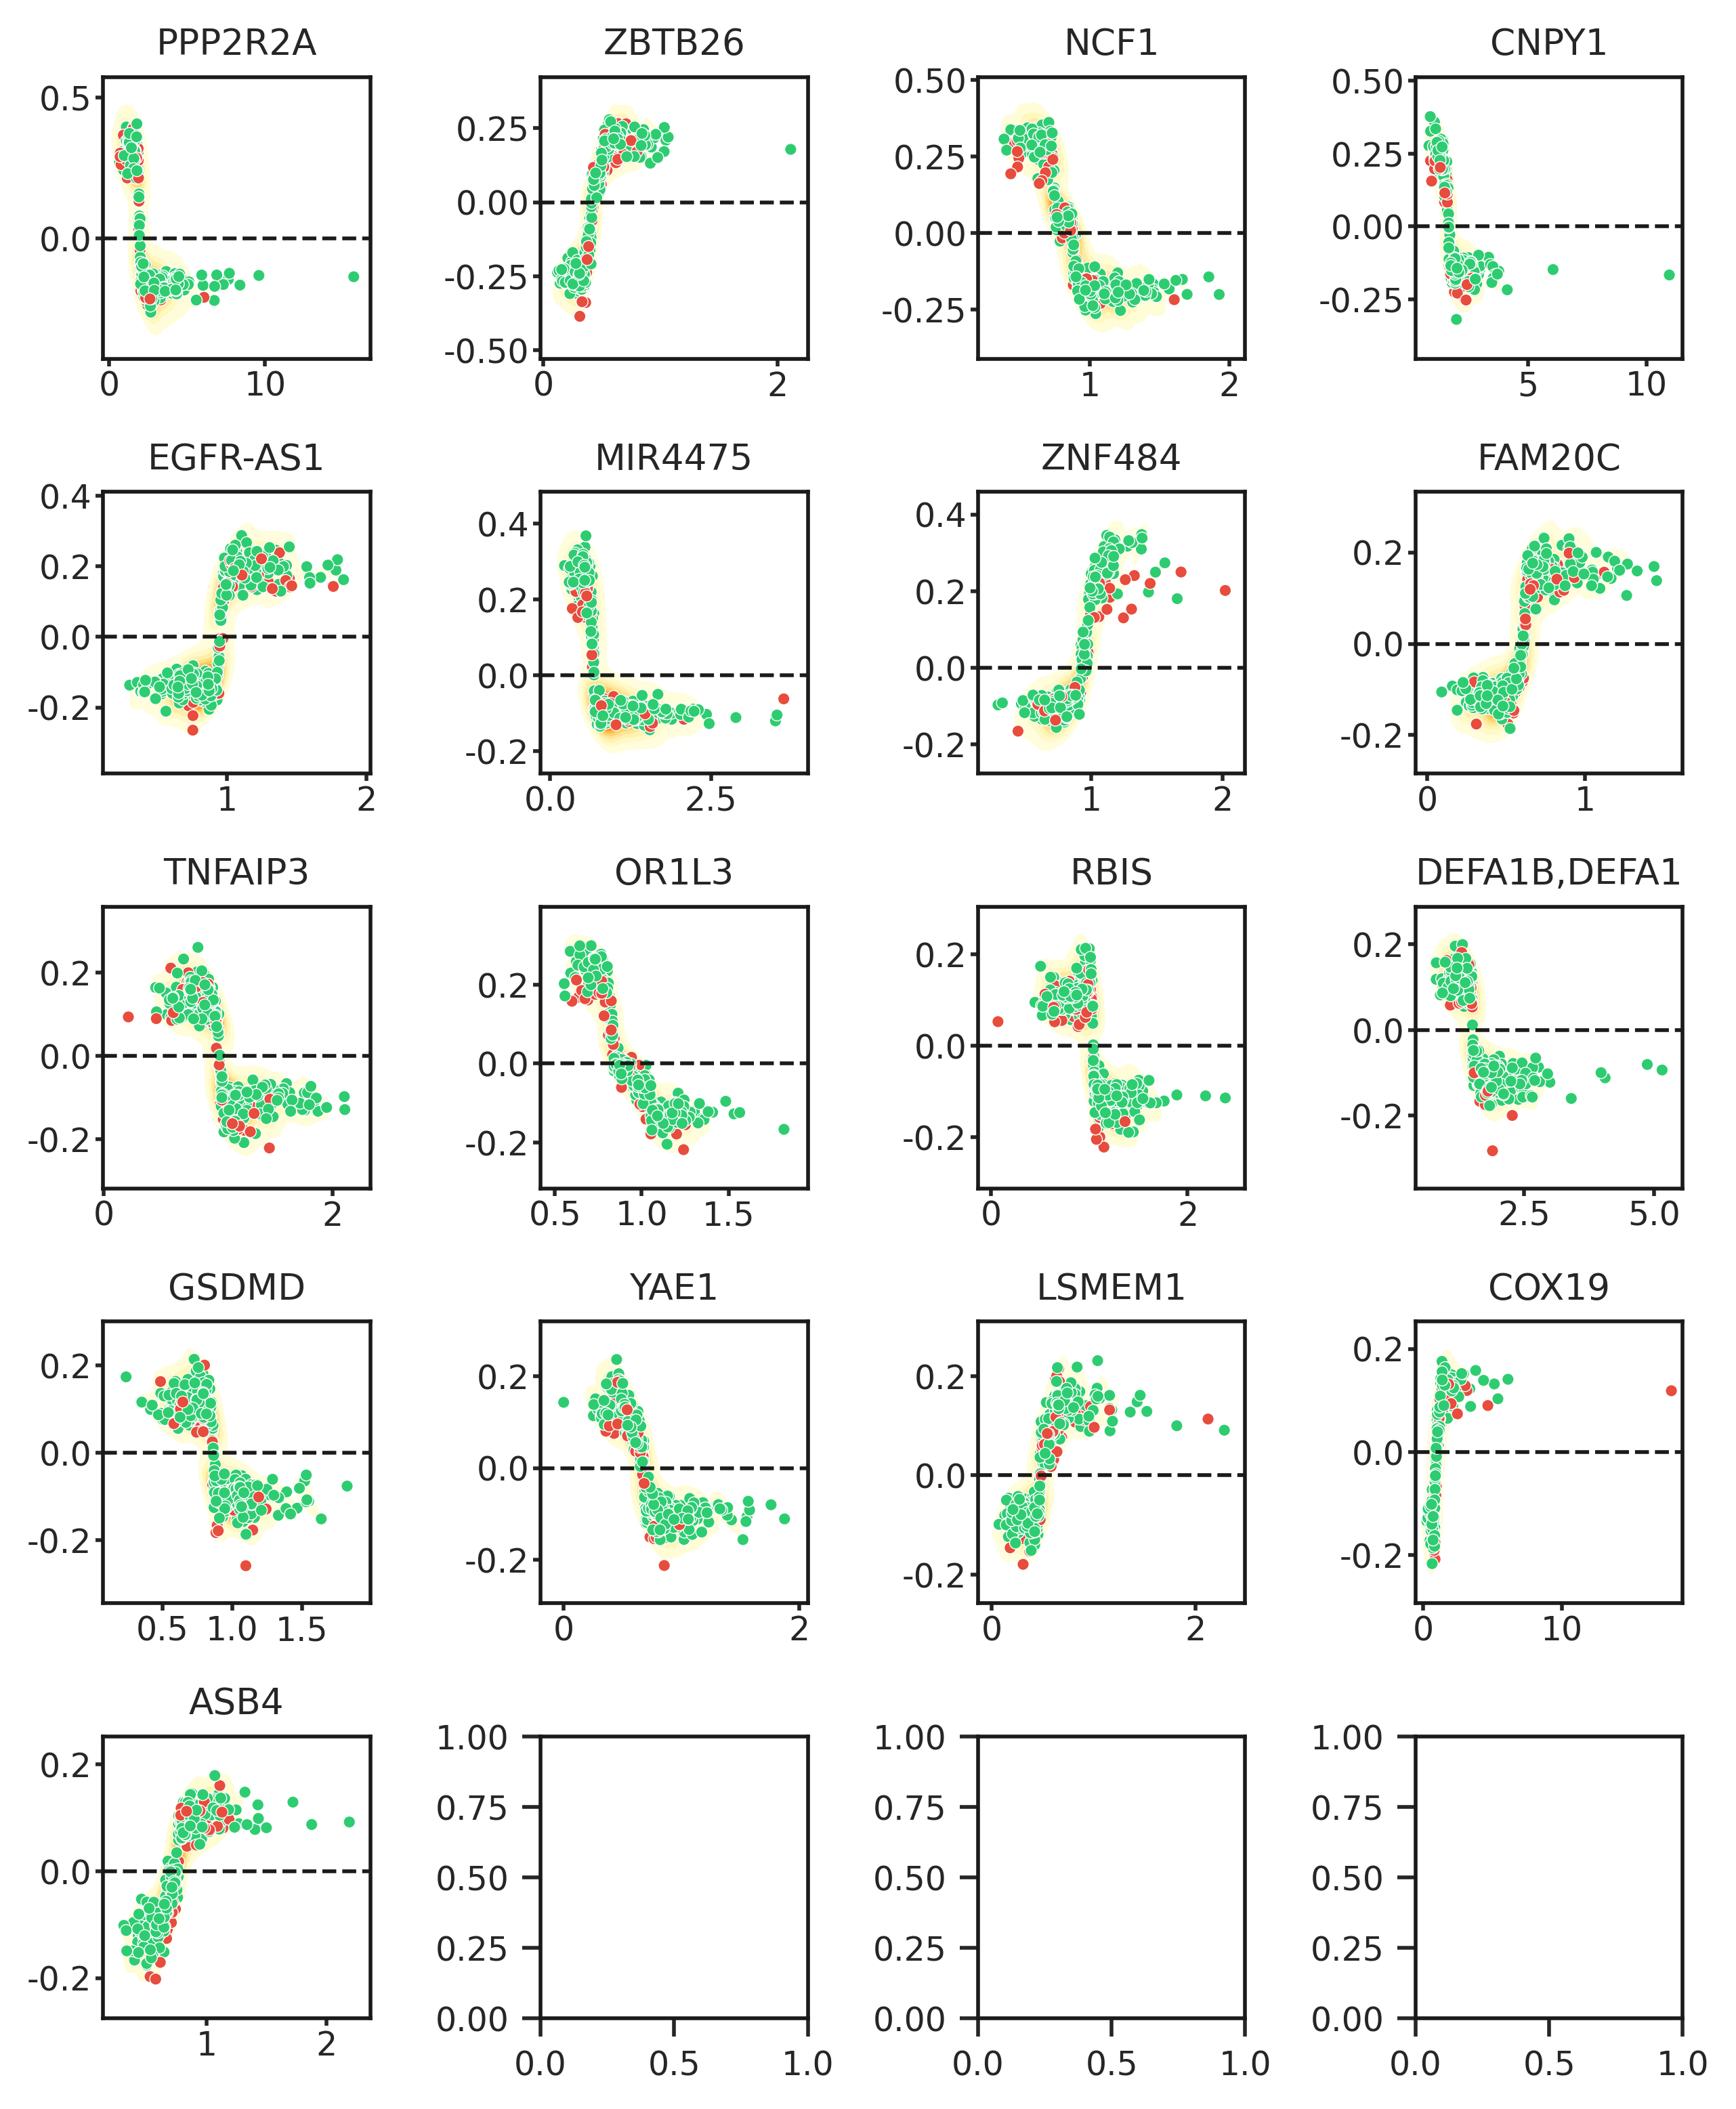

In [103]:
n_feat_tss = len(tss_shap_value.columns.tolist()[2:])
plot_col_n = 4
    
fig, axs = plt.subplots(int(np.ceil(n_feat_tss/plot_col_n)),plot_col_n,
                        figsize=(16.5*centimeter,4*int(np.ceil(n_feat_tss/plot_col_n))*centimeter))
axs = axs.ravel()

for idddx, tss_name_i in enumerate(tss_shap_value.columns.tolist()[2:]):
    
    sns.kdeplot(x=tss_shap_data_values['{}_x'.format(tss_name_i)], 
                y=tss_shap_data_values['{}_y'.format(tss_name_i)], cmap="YlOrBr", shade=True, bw_adjust=.7,ax=axs[idddx])
    
    sns.scatterplot(data=tss_shap_data_values, x='{}_x'.format(tss_name_i), 
                    y='{}_y'.format(tss_name_i),edgecolors=None,
                    hue="labels",palette=palette, ax=axs[idddx],s=10)
    
    axs[idddx].axhline(y=0, ls='--', lw=1,c='k')
    axs[idddx].set_ylabel(None)
    axs[idddx].set_xlabel(None)
    axs[idddx].set_title(tss_name_i)
    
    axs[idddx].tick_params(direction='out', length=2, pad=1, width=1)
    
    axs[idddx].get_legend().remove()
plt.tight_layout()
plt.savefig("results_plt/feat_shap_values_real_m2model_tss.pdf", dpi=400, bbox_inches='tight')

/zfssz2/ST_MCHRI/BIGDATA/USER/baiyong/anaconda3/lib/python3.6/site-packages/statannotations/Annotator.py:795: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "
/zfssz2/ST_MCHRI/BIGDATA/USER/baiyong/anaconda3/lib/python3.6/site-packages/statannotations/Annotator.py:795: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "
/zfssz2/ST_MCHRI/BIGDATA/USER/baiyong/anaconda3/lib/python3.6/site-packages/statannotations/Annotator.py:795: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "
/zfssz2/ST_MCHRI/BIGDATA/USER/baiyong/anaconda3/lib/python3.6/site-packages/statannotations/Annotator.py:7

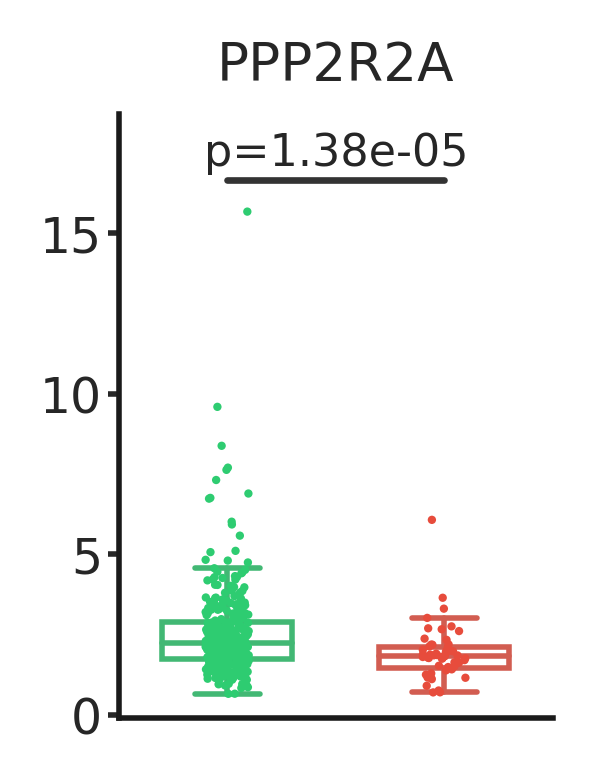

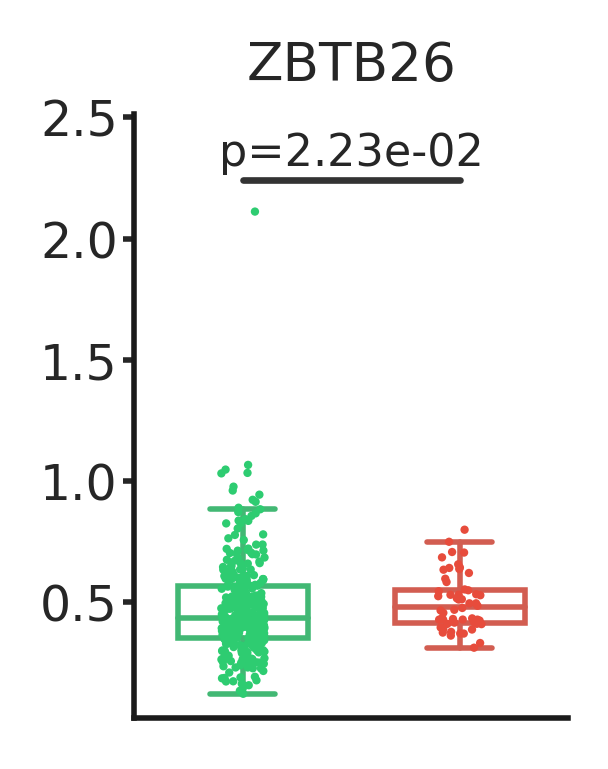

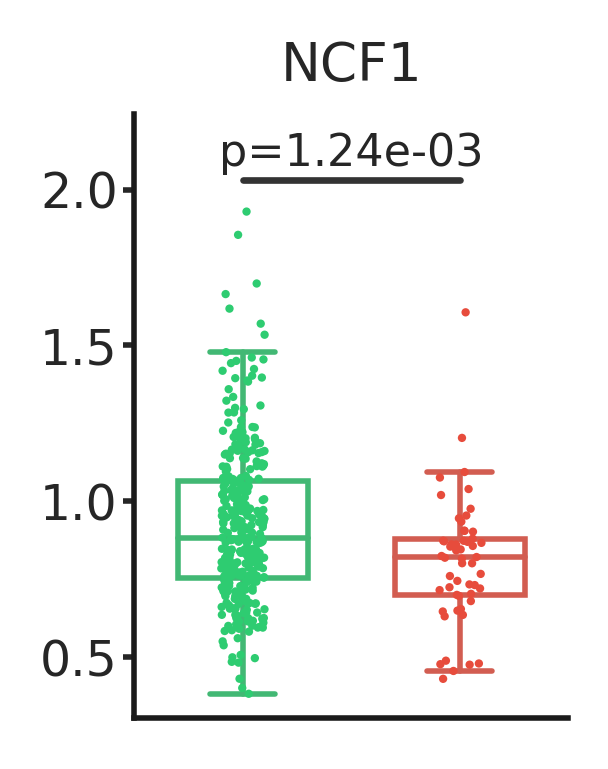

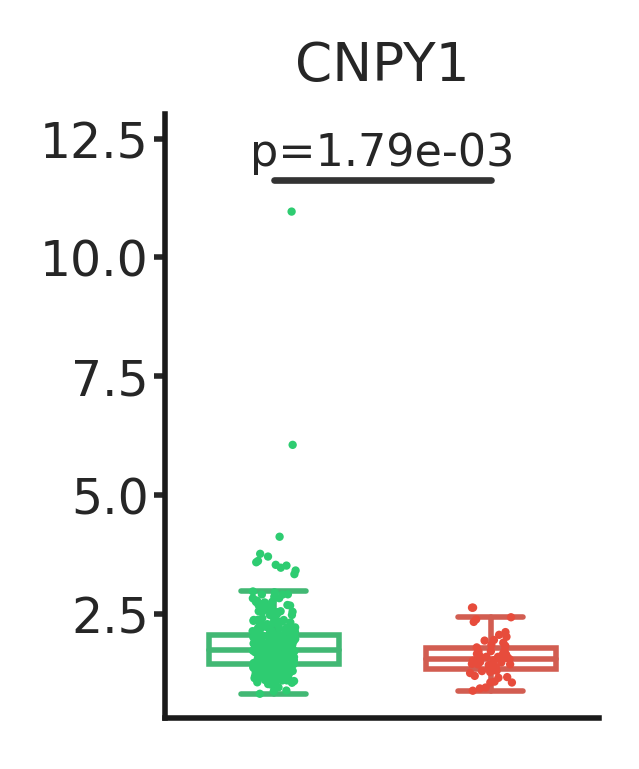

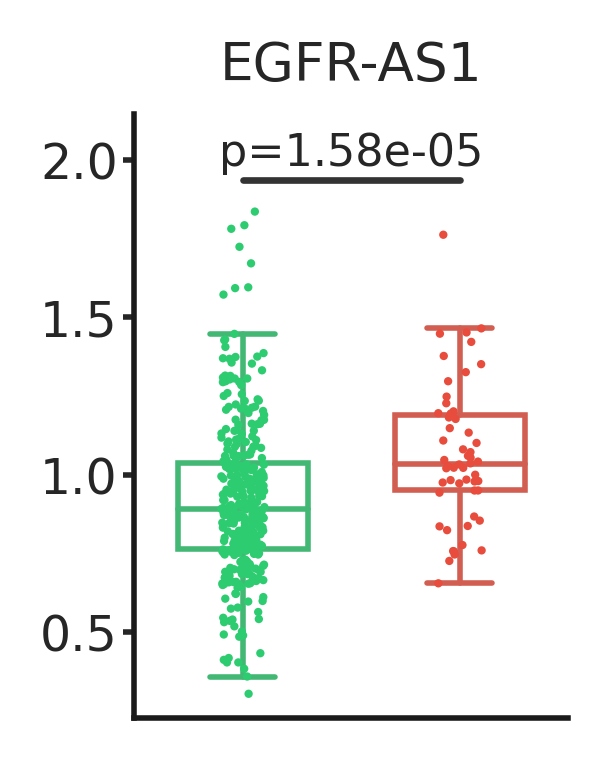

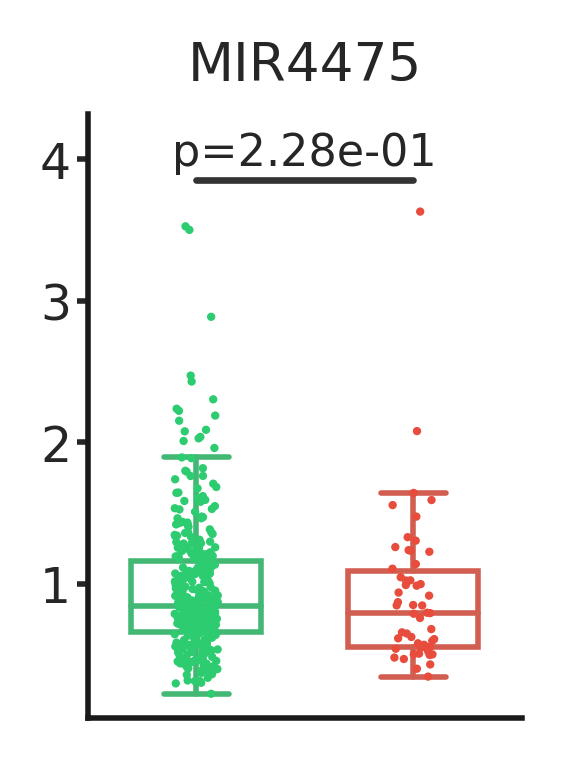

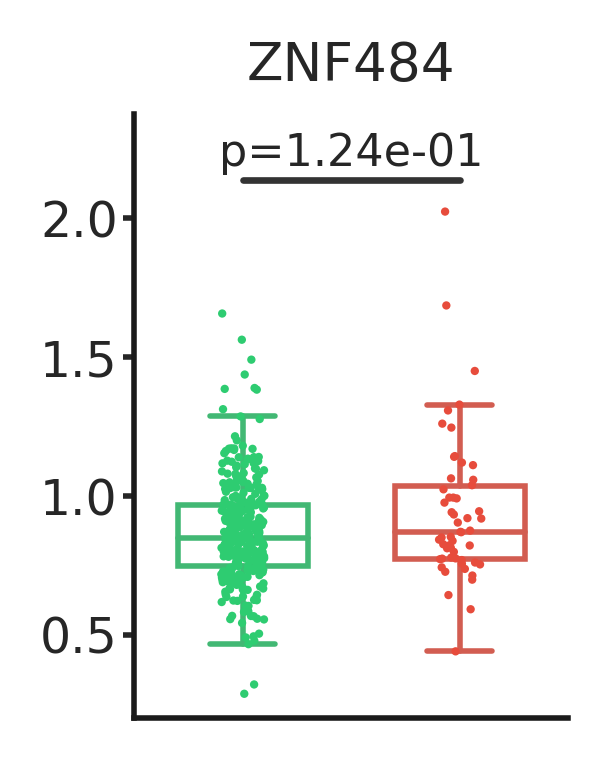

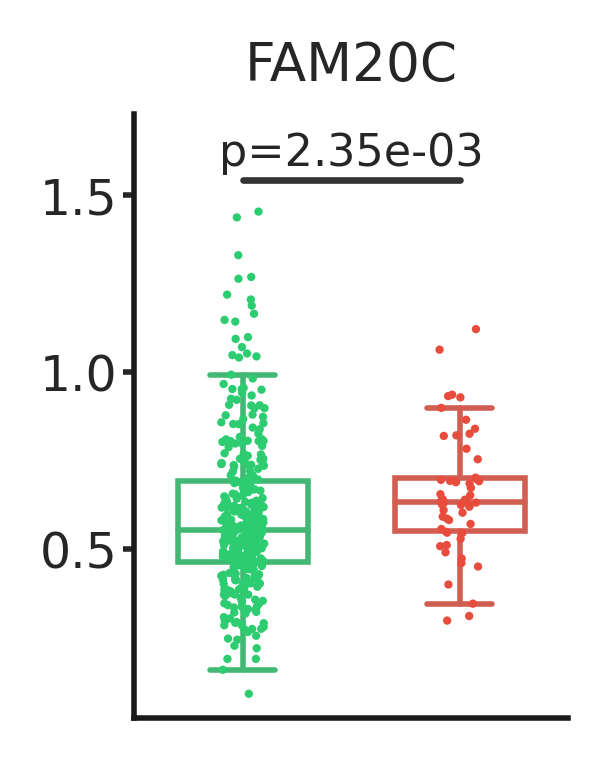

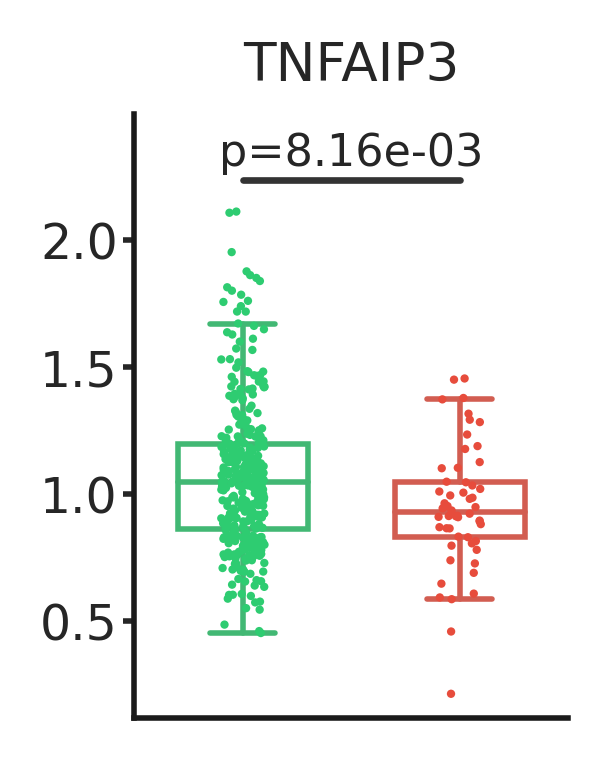

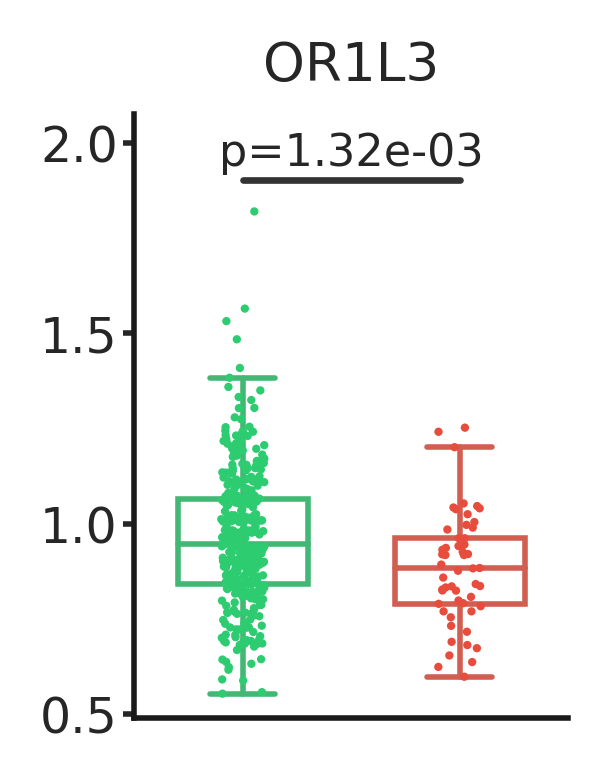

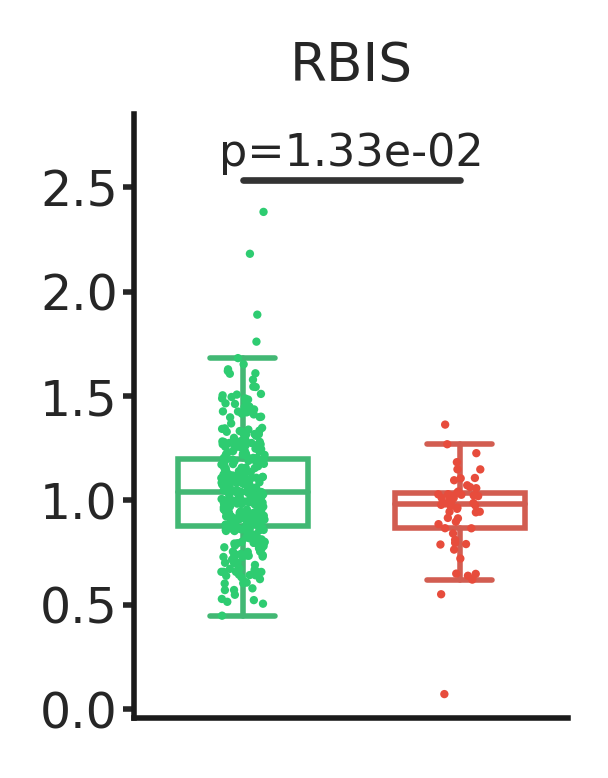

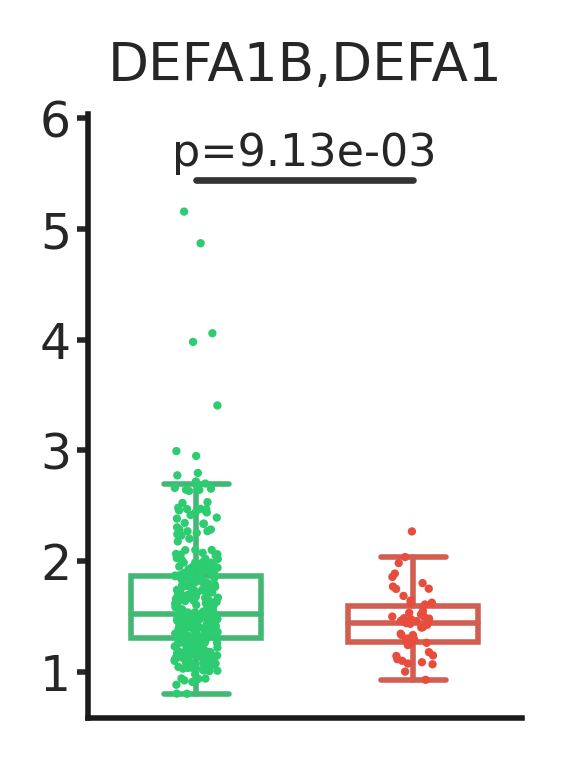

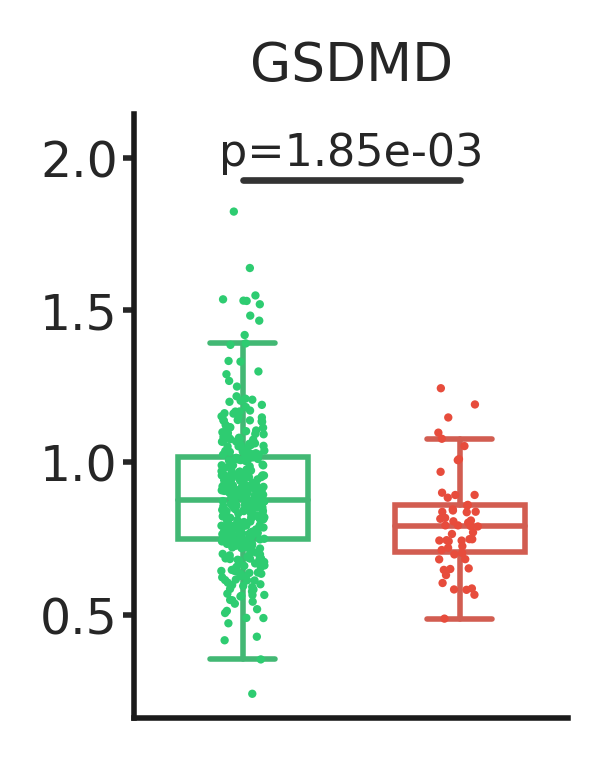

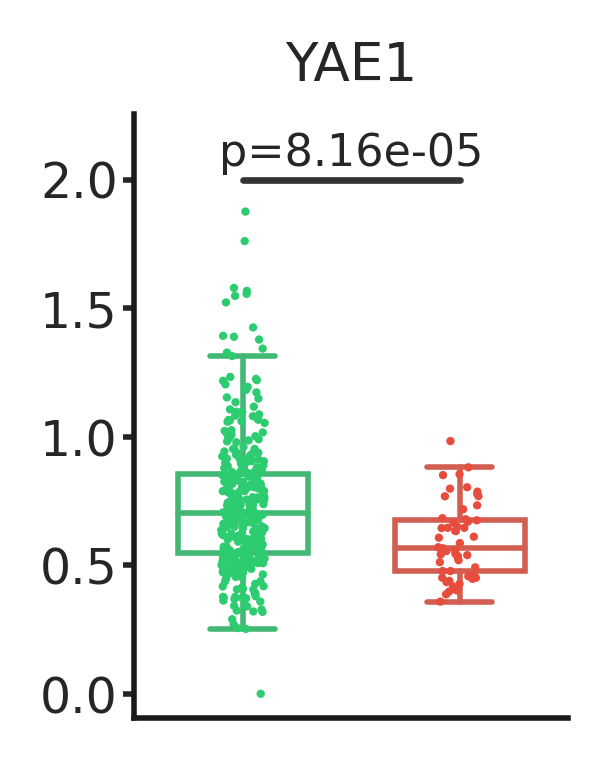

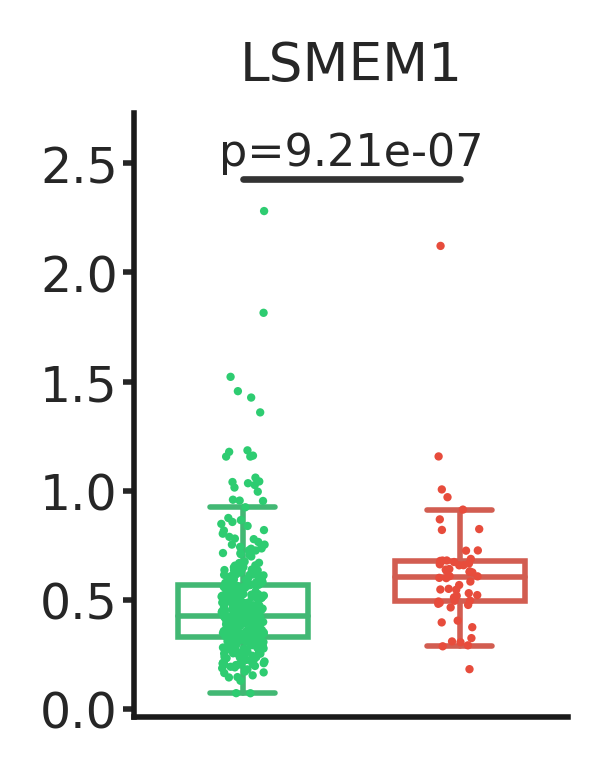

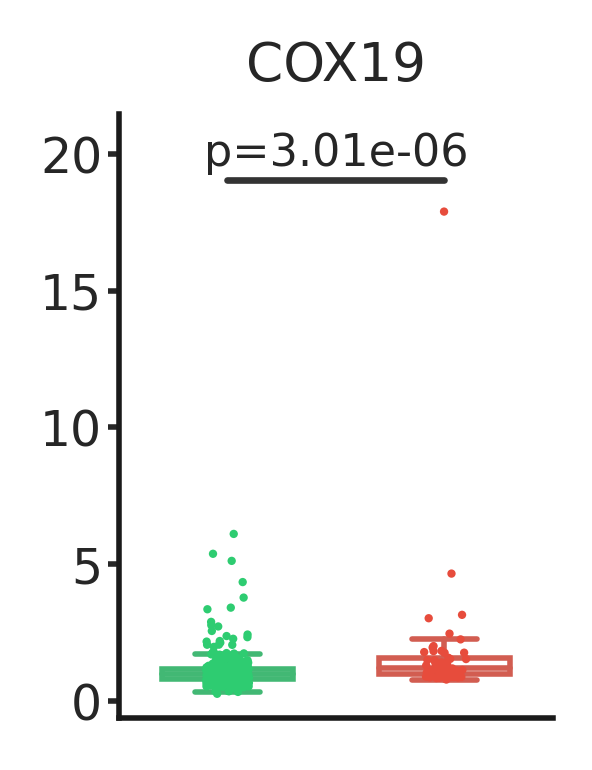

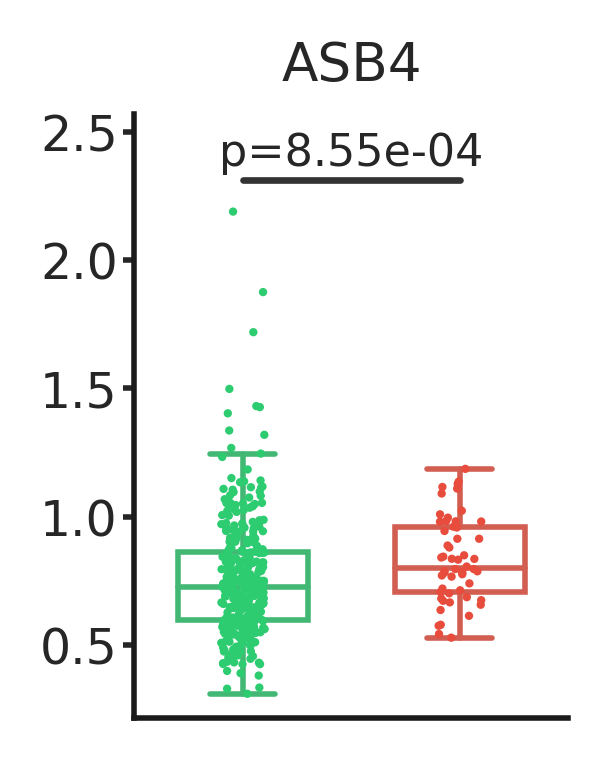

In [42]:
from statannotations.Annotator import Annotator
from scipy.stats import mannwhitneyu

# fig, axs = plt.subplots(1,len(i_feats_name), figsize=(6.8,2))
orders = ['Noncritical','Critical']
palette = dict(zip(orders, ['#2ecc71','#e74c3c']))

for ix in range(len(tss_names)):
    
    fig, axs = plt.subplots(1,1,figsize=(1.4,2))

    plot_param={
        'data':tss_raw_dat,
        'x':'labels',
        'y':tss_genes_map[tss_names[ix]],
        'order':orders,
        'orient':'v'
    }

    sns.stripplot(**plot_param, ax=axs,palette=palette,size=1.5)
    axa = sns.boxplot(**plot_param,ax=axs,palette=palette, showfliers=False, linewidth=1,width=0.6)

    for i,artist in enumerate(axs.artists):
        # Set the linecolor on the artist to the facecolor, and set the facecolor to None
        col = artist.get_facecolor()
        artist.set_edgecolor(col)
        artist.set_facecolor('None')

        # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same colour as above
        for j in range(i*5,i*5+5):
            line = axa.lines[j]
            line.set_color(col)
            line.set_mfc(col)
            line.set_mec(col)

    noncri_values = tss_raw_dat.loc[tss_raw_dat['labels']=='Noncritical',
                                  tss_genes_map[tss_names[ix]]].values
    cri_values = tss_raw_dat.loc[tss_raw_dat['labels']=='Critical',
                               tss_genes_map[tss_names[ix]]].values

    pvalues=[mannwhitneyu(noncri_values, cri_values, alternative="two-sided").pvalue]

    formatted_pvalues = [f"p={p:.2e}" for p in pvalues]

    anno_pairs= [(orders[0], orders[1])]
    annot = Annotator(axa, pairs=anno_pairs, **plot_param)
    annot.reset_configuration()
    annot.set_custom_annotations(formatted_pvalues)
    annot.configure(verbose=False,line_width=1.2,fontsize=8,loc='inside',line_height=0, text_offset=1)
    annot.annotate()
    # if labs_names[ix]=='LDH':
    #     axa.set_yscale('log') 
    #     axa.set_ylim((80,3000))
    # elif labs_names[ix]=='Uric_acid': 
    #     axa.set_ylim((-50,900))
    # elif labs_names[ix]=='α-HBDH': 
    #     axa.set_ylim((50,700))
    # else:
    #     axa.set_ylim((-50,650))
    
    axa.set_ylabel(None)
    # axa.set_title(r'$\it{}$'.format(tss_genes_map[tss_names[ix]]))
    axa.set_title(tss_genes_map[tss_names[ix]])
    axa.set_xlabel(None)
    axa.set_xticks([])

    # axa.set_xticklabels(axa.get_xticklabels(),rotation=30, ha='right')
    axa.tick_params(direction='out', length=2, pad=1, width=1)
    sns.despine()
    plt.savefig("results_plt/feat_real_tss_dist_{}_{}.pdf".format(tss_names[ix], tss_genes_map[tss_names[ix]]), 
                dpi=400, bbox_inches='tight')

## TSS pathway analysis

 We only analysis top 21 feature, 4 lab and 17 tss

In [9]:
# load tss pathway data 

covid19_gene_set_fname = r'enrichr-18/COVID-19_Related_Gene_Sets_2021_table.txt'
go_bp_fname = r'enrichr-18/GO_Biological_Process_2021_table.txt'
go_cc_fname = r'enrichr-18/GO_Cellular_Component_2021_table.txt'
go_func_fname = r'enrichr-18/GO_Molecular_Function_2021_table.txt'
kegg_fname = r'enrichr-18/KEGG_2021_Human_table.txt'

covid19_gene_set_dat =pd.read_csv(os.path.join(raw_data_dir, covid19_gene_set_fname), sep='\t') # 163 items
covid19_gene_set_dat['neg_log10_p'] = -np.log10(covid19_gene_set_dat['P-value'].values)

go_bp_dat =pd.read_csv(os.path.join(raw_data_dir, go_bp_fname), sep='\t') # 182 items
go_bp_dat['neg_log10_p'] = -np.log10(go_bp_dat['P-value'].values)
go_bp_dat['Term'] = go_bp_dat['Term'].str.replace(r"\s*\(.*\)\s*","")

go_cc_dat =pd.read_csv(os.path.join(raw_data_dir, go_cc_fname), sep='\t') # 31 items
go_cc_dat['neg_log10_p'] = -np.log10(go_cc_dat['P-value'].values)
go_cc_dat['Term'] = go_cc_dat['Term'].str.replace(r"\s*\(.*\)\s*","")

go_func_dat =pd.read_csv(os.path.join(raw_data_dir, go_func_fname), sep='\t') # 38 items
go_func_dat['neg_log10_p'] = -np.log10(go_func_dat['P-value'].values)
go_func_dat['Term'] = go_func_dat['Term'].str.replace(r"\s*\(.*\)\s*","")

kegg_dat =pd.read_csv(os.path.join(raw_data_dir, kegg_fname), sep='\t') # 35 items
kegg_dat['neg_log10_p'] = -np.log10(kegg_dat['P-value'].values)


### GO and KEGG


In [10]:
kegg_dat.head()

Term Overlap   P-value  \
0      NOD-like receptor signaling pathway   4/181  0.000018   
1          Staphylococcus aureus infection    2/95  0.003251   
2  Neutrophil extracellular trap formation   2/189  0.012304   
3  Transcriptional misregulation in cancer   2/192  0.012679   
4                            Leishmaniasis    1/77  0.067105   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0          0.000629            0                     0   31.969330   
1          0.056887            0                     0   26.732527   
2          0.110941            0                     0   13.231952   
3          0.110941            0                     0   13.021053   
4          0.206658            0                     0   15.407121   

   Combined Score                       Genes  neg_log10_p  
0      349.304587  GSDMD;TNFAIP3;DEFA1;DEFA1B     4.745206  
1      153.147502                DEFA1;DEFA1B     2.488022  
2       58.191452                  GSDMD;NCF1     1.909939  
3       56.873476                DEFA1;DEFA1B     1.896916  
4       41.622198                        NCF1     1.173243

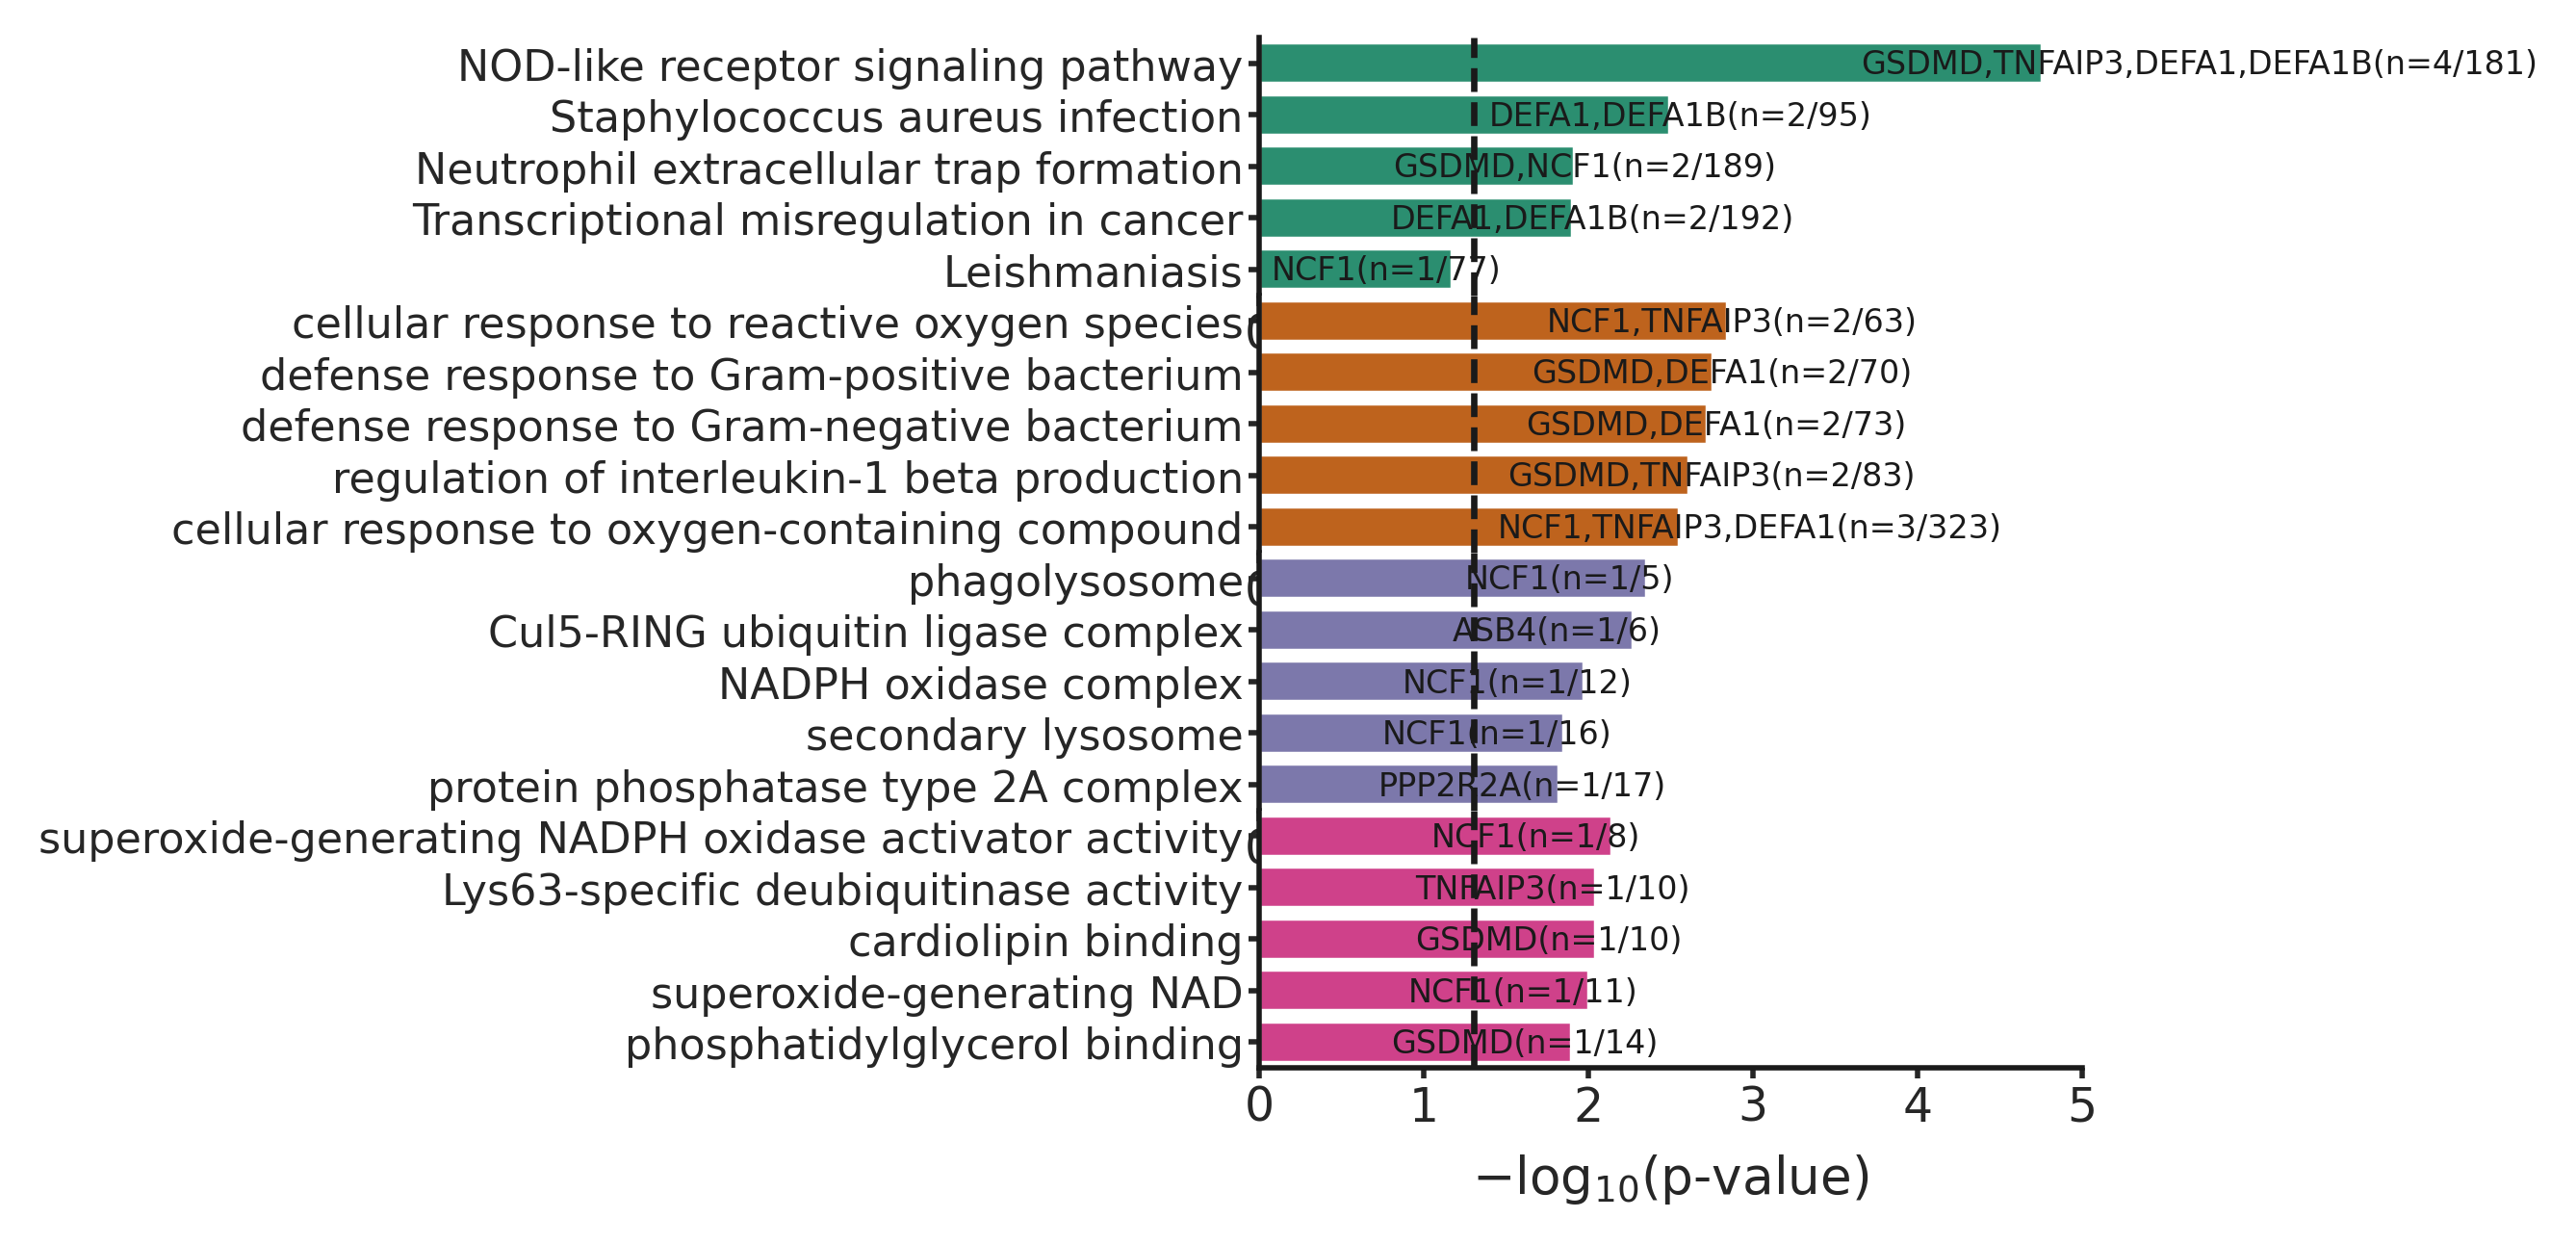

In [16]:
from matplotlib.gridspec import GridSpec

colrs = '#1b9e77,#d95f02,#7570b3,#e7298a'.split(',')
fig = plt.figure(figsize=(7*centimeter,9*centimeter))

gs = fig.add_gridspec(4, 1,hspace=0)
ax0 = fig.add_subplot(gs[0],)
ax1 = fig.add_subplot(gs[1],sharex=ax0)
ax2 = fig.add_subplot(gs[2],sharex=ax0)
ax3 = fig.add_subplot(gs[3],sharex=ax0)

axs = [ax0,ax1,ax2,ax3]

for k_dx, k_go_kegg_dat in enumerate([kegg_dat.head(),go_bp_dat.head(), go_cc_dat.head(), go_func_dat.head()]):
    
    axa = sns.barplot(x="neg_log10_p", y="Term", data=k_go_kegg_dat,ax=axs[k_dx],color=colrs[k_dx])
    
    for ixx,i_row in k_go_kegg_dat.iterrows():
        # i_genes = [r'$\it{}$'.format(x.strip()) for x in i_row['Genes'].split(';')]
        i_genes = [x.strip() for x in i_row['Genes'].split(';')]
        neg_p=i_row['neg_log10_p']
        # axa.text(neg_p-1.1,ixx+0.2, ','.join(i_genes)+'(n={})'.format(len(i_genes)), fontsize=6, color='k')
        axa.text(neg_p-1.1,ixx+0.2, ','.join(i_genes)+'(n={})'.format(i_row['Overlap']), fontsize=6, color='k')
    
    axa.spines['top'].set_visible(False)
    axa.spines['right'].set_visible(False)
    
    if k_dx < 3:
        axs[k_dx].spines['bottom'].set_visible(False)
        # axa.set_xticks([])
    
    axa.axvline(x = -np.log10(0.05),color='k',ls='--')
    axa.set_yticklabels(axa.get_yticklabels(),fontsize=8)
    axa.set_xlabel(r'$-\log_{10}$(p-value)')
    axa.set_ylabel(None)
    axa.set_xticks([0,1,2,3,4,5])
    axa.tick_params(direction='out', length=2, pad=1, width=1)

plt.savefig("results_plt/feat_tss_pathway.pdf", dpi=400, bbox_inches='tight')
    

In [48]:
-np.log10(0.05)

1.3010299956639813

#### COVID-19 Gene Set

In [69]:
covid19_gene_set_dat

Term Overlap   P-value  \
0    SARS-CoV perturbation; 7 Up Genes from GEN3VA;...     1/7  0.006284   
1    500 genes up-regulated by SARS-CoV-2 in human ...   3/461  0.007673   
2    500 genes up-regulated by SARS-CoV-2 in human ...   3/490  0.009068   
3    SARS-CoV perturbation; 23 Up Genes from GEN3VA...    1/23  0.020507   
4    Coronavirus Perturbation; 326 Up Genes from GE...   2/266  0.023434   
..                                                 ...     ...       ...   
158  Top 500 down genes for SARS-CoV-2 late-stage i...   1/498  0.364961   
159  Top 500 down genes for SARS-CoV-2 middle-stage...   1/498  0.364961   
160                          COVID-19 patients PBMC up   1/514  0.374278   
161  Top 772 negative hits from genome-wide CRISPR ...   1/730  0.488076   
162  Top 797 negative hits from genome-wide CRISPR ...   1/753  0.498968   

     Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0            0.330484            0                     0  195.843137   
1            0.330484            0                     0    8.525764   
2            0.330484            0                     0    8.006160   
3            0.330484            0                     0   53.368984   
4            0.330484            0                     0    9.336174   
..                ...          ...                   ...         ...   
158          0.371804            0                     0    2.306190   
159          0.371804            0                     0    2.306190   
160          0.378928            0                     0    2.232427   
161          0.491089            0                     0    1.553538   
162          0.498968            0                     0    1.504224   

     Combined Score                Genes  neg_log10_p  
0        992.879272              TNFAIP3     2.201772  
1         41.520782  NCF1;LSMEM1;TNFAIP3     2.115030  
2         37.652562  NCF1;LSMEM1;TNFAIP3     2.042465  
3        207.443686              TNFAIP3     1.688090  
4         35.043826       ZNF484;TNFAIP3     1.630147  
..              ...                  ...          ...  
158        2.324558                 RBIS     0.437753  
159        2.324558                 RBIS     0.437753  
160        2.193932               FAM20C     0.426806  
161        1.114329                 NCF1     0.311513  
162        1.045756                 NCF1     0.301927  

[163 rows x 10 columns]

In [77]:
signif_genesets = covid19_gene_set_dat.head(11)
signif_genesetss = signif_genesets[['Term','Genes','Overlap','P-value']].copy()
signif_genesetss['GSE']=signif_genesets['Term'].str.extract(r'(GSE\d+)')



In [78]:
signif_genesetss

Term                Genes  \
0   SARS-CoV perturbation; 7 Up Genes from GEN3VA;...              TNFAIP3   
1   500 genes up-regulated by SARS-CoV-2 in human ...  NCF1;LSMEM1;TNFAIP3   
2   500 genes up-regulated by SARS-CoV-2 in human ...  NCF1;LSMEM1;TNFAIP3   
3   SARS-CoV perturbation; 23 Up Genes from GEN3VA...              TNFAIP3   
4   Coronavirus Perturbation; 326 Up Genes from GE...       ZNF484;TNFAIP3   
5   SARS perturbation; 388 Up Genes from GEN3VA; H...         NCF1;TNFAIP3   
6   Top 500 up genes for SARS-CoV-2 infection in M...        GSDMD;TNFAIP3   
7   Top 500 up genes for SARS-CoV-2 infection in M...        GSDMD;TNFAIP3   
8   Top 500 up genes for SARS-CoV-2 infection in M...        GSDMD;TNFAIP3   
9   Top 500 upregulated genes in human nasal epith...      TNFAIP3;PPP2R2A   
10  Top 500 upregulated genes in mouse kidney with...        GSDMD;TNFAIP3   

   Overlap   P-value        GSE  
0      1/7  0.006284   GSE30589  
1    3/461  0.007673  GSE150392  
2    3/490  0.009068  GSE150392  
3     1/23  0.020507   GSE30589  
4    2/266  0.023434   GSE45042  
5    2/342  0.037245   GSE47961  
6    2/363  0.041504  GSE162208  
7    2/370  0.042963  GSE162208  
8    2/377  0.044442  GSE162208  
9    2/398  0.048993  GSE162131  
10   2/399  0.049214  GSE162113

In [ ]:
signif_genesetss.to_csv('results_plt/covid19_gene_set.csv', sep='\')

In [41]:
signif_genesets.iloc[0,0]

'SARS-CoV perturbation; 7 Up Genes from GEN3VA; Human Vero E6 cells; Accession: GSE30589 Platform: GPL570 Entry 3'

In [52]:
signif_genesets.iloc[1,0]

'500 genes up-regulated by SARS-CoV-2 in human cardiomyocytes from GSE150392'

In [53]:
signif_genesets.iloc[2,0]

'500 genes up-regulated by SARS-CoV-2 in human hiPSC-CMs cells at 24h from GSE150392'

In [54]:
signif_genesets.iloc[3,0]

'SARS-CoV perturbation; 23 Up Genes from GEN3VA; Human Vero E6 cells; Accession: GSE30589 Platform: GPL570 Entry 4'

In [55]:
signif_genesets.iloc[4,0]

'Coronavirus Perturbation; 326 Up Genes from GEN3VA Human Calu-3 2B4 cells; Accession: GSE45042 Platform: GPL6480 Entry 2'

In [56]:
signif_genesets.iloc[5,0]

'SARS perturbation; 388 Up Genes from GEN3VA; Human airway epithelium (HAE) cells; Accession: GSE47961 Platform: GPL6480; Entry 4'

In [57]:
signif_genesets.iloc[6,0]

'Top 500 up genes for SARS-CoV-2 infection in Mesocricetus auratus hamster blood Day 2 from GSE162208'

In [40]:
signif_genesets.iloc[7,0]

'Top 500 up genes for SARS-CoV-2 infection in Mesocricetus auratus hamster lung Day 3 from GSE162208'

In [42]:
signif_genesets.iloc[8,0]

'Top 500 up genes for SARS-CoV-2 infection in Mesocricetus auratus hamster lung Day 5 from GSE162208'

In [43]:
signif_genesets.iloc[9,0]

'Top 500 upregulated genes in human nasal epithelial cells with SARS-CoV-2 infection (Mutant, 72 hpi) from GEO GSE162131'

In [44]:
signif_genesets.iloc[10,0]

'Top 500 upregulated genes in mouse kidney with SARS-CoV-2 infection (Day 3) from GEO GSE162113'

## Case Analysis

In [9]:
import shap

def sigmoid(x): return 1./(1. +  np.exp(-x))

max_feat_idx_ap = {'lab': 14, 'fragl': 6, 'tss': 31, 'motif': 28, 'm2model': 20}
i_feat_type = 'm2model'

# i_re_perf_fname = os.path.join(model_re_root_dir, '{}/32_fl_entire_feat_retrain-auc.pkl'.format(i_feat_type))
i_re_perf_fname = os.path.join(model_re_root_dir, '{}/34_fl_prefeature_performance.pkl'.format(i_feat_type))
with open(i_re_perf_fname, 'rb') as f:
    perf_feats = pickle.load(f)


pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


In [10]:
opt_feats_model = perf_feats[max_feat_idx_ap[i_feat_type]]

In [11]:
m2model_feats = load_feat_importance_shap('m2model')['feat_name'].values

featnames = load_all_feats_name()
f_type=[]
for f in m2model_feats:
    for iiidx, t in enumerate('lab,fragl,tss,motif'.split(',')):
        if f in featnames[t]:
            f_type.append(t)
            break

f_type = np.array(f_type)

# lab
labs_names = m2model_feats[f_type=='lab']
lab_raw_dat = pd.read_csv(os.path.join(raw_data_dir, '399_labtest_fill.csv'))
lab_feat_data = lab_raw_dat[['ind','new_triage']+labs_names.tolist()].copy()

# tss
tss_names = m2model_feats[f_type=='tss']
tss_raw_dat_fname = os.path.join(raw_data_dir, 'tss.fillna.pkl')
with open(tss_raw_dat_fname, 'rb') as f:
    tss_raw_dat = pickle.load(f)[['ind','label']+tss_names.tolist()].copy()
tss_raw_dat.rename(columns={"label": "new_triage"}, inplace=True)
lab_tss_real_0 = lab_feat_data.merge(tss_raw_dat, on=['ind','new_triage'])



elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [12]:
lab_tss_real=lab_tss_real_0[['ind','new_triage']+opt_feats_model[0]].copy()

# genes = [tss_gene_df.loc[tss_gene_df['tss']==x, 'gene'].values[0] for x in tss_names]
# # geness = ['DEFA1' if x == 'DEFA1B,DEFA1' else x for x in genes]
# geness=genes
# tss_genes_map = dict(zip(tss_names, geness))

# lab_tss_real.rename(columns=tss_genes_map, inplace=True)
# lab_tss_real.rename(columns={'Uric_acid':'UA'}, inplace=True)

In [13]:
norm_trn_df_dd = pd.read_csv(os.path.join(model_re_root_dir, i_feat_type+'/00_trn_df.csv'),sep='\t')
norm_tst_df_dd = pd.read_csv(os.path.join(model_re_root_dir, i_feat_type+'/00_tst_df.csv'),sep='\t')
norm_df_dd = pd.concat([norm_trn_df_dd,norm_tst_df_dd])[['ind','new_triage']+opt_feats_model[0]].copy()


In [15]:
raw_dd_p = lab_tss_real[lab_tss_real['ind']==pid].iloc[:,2:]
norm_dd_p = norm_df_dd[norm_df_dd['ind']==pid].iloc[:,2:]

In [28]:
raw_dd_p

LDH  gene_0_36079  gene_1_38365  gene_1_34557  gene_1_35660  \
279  296.0      1.982162      0.576668      0.626387      1.693403   

     gene_0_34371  Uric_acid  α-HBDH  gene_1_37604  gene_0_37969  ...  \
279      1.060684       86.6   225.0      0.648853      0.889891  ...   

     gene_1_33376  gene_0_38356  gene_1_36592  gene_0_35754  gene_0_37102  \
279      1.086597      1.017354      1.173882      1.542924      0.673109   

     gene_0_34227     PA  gene_0_35092  gene_1_33775  gene_1_34781  
279      1.388573  146.8      0.418163      2.723887      0.730704  

[1 rows x 21 columns]

In [16]:
norm_dd_p

LDH  gene_0_36079  gene_1_38365  gene_1_34557  gene_1_35660  \
304  0.670062     -0.327148      0.556881     -1.137686     -0.165886   

     gene_0_34371  Uric_acid    α-HBDH  gene_1_37604  gene_0_37969  ...  \
304       0.52647  -1.923075  1.039549     -0.612205      0.083432  ...   

     gene_1_33376  gene_0_38356  gene_1_36592  gene_0_35754  gene_0_37102  \
304      0.154778      0.405857      0.513606     -0.134663     -0.901935   

     gene_0_34227       PA  gene_0_35092  gene_1_33775  gene_1_34781  
304      2.615667 -1.70581     -0.305426      1.375493     -0.144778  

[1 rows x 21 columns]

In [17]:
it100_pred_re = pd.read_csv('results_plt/100iters_tst_preds_399pat_m2model_20.csv',sep='\t')

model_idx = [int(x[8:]) for x in \
             it100_pred_re.columns[it100_pred_re[it100_pred_re.ind==pid].notnull().any()].tolist()[2:]]

In [18]:
# i_re = perf_feats[0]
preds_df = []
for n_idx, i_re in enumerate(opt_feats_model[1]): 
    if n_idx not in model_idx:
        continue
    # https://github.com/slundberg/shap/issues/632
    explainer = shap.TreeExplainer(i_re[0])
    expected_val = explainer.expected_value
    
    shap_values_t = explainer.shap_values(norm_dd_p.values)
    # abs_shap_sum = np.sum(np.abs(i_re[3]),1)
    # abs_shap_sum = np.sum(i_re[3],1)
    # for i in range(shap_values_t.shape[0]):
    #     shap_values_t[i]=shap_values_t[i]/abs_shap_sum[i]
    out_pred={}
    out_pred['exp_val'] = expected_val
    out_pred['y_pred_loglike'] = sigmoid(i_re[0].predict(norm_dd_p.values))
    
    preds_df.append(pd.concat([pd.DataFrame(out_pred), 
                               pd.DataFrame(shap_values_t, columns=i_re[0].feature_name())], axis=1))
    
preds_df_p = pd.concat(preds_df)
preds_df_p.reset_index(drop=True,inplace=True)
# f_pred_df = all_tmp_preds_df.groupby('ind').mean()

In [19]:
preds_df_p_mean = pd.DataFrame(preds_df_p.mean(),columns=['shap_val'])

In [22]:
featnames = load_all_feats_name()
f_type=[]
for f in m2model_feats:
    for iiidx, t in enumerate('lab,fragl,tss,motif'.split(',')):
        if f in featnames[t]:
            f_type.append(t)
            break

f_type = np.array(f_type)

tss_names = m2model_feats[f_type=='tss']
genes = [tss_gene_df.loc[tss_gene_df['tss']==x, 'gene'].values[0] for x in tss_names]
# geness = ['DEFA1' if x == 'DEFA1B,DEFA1' else x for x in genes]
geness=genes
tss_genes_map = dict(zip(tss_names, geness))

preds_df_p_mean_feat = preds_df_p_mean.iloc[2:,:].copy()
preds_df_p_mean_feat.sort_values(by='shap_val',ascending = True, inplace=True)
preds_df_p_mean_feat=preds_df_p_mean_feat.T
preds_df_p_mean_feat.rename(columns=tss_genes_map, inplace=True)
preds_df_p_mean_feat.rename(columns={'Uric_acid':'UA'}, inplace=True)

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [23]:
preds_df_p_mean_feat

YAE1   TNFAIP3    LSMEM1      RBIS    FAM20C    ZNF484  \
shap_val -0.425315 -0.272942 -0.241984 -0.232836 -0.181897 -0.056707   

             OR1L3  DEFA1B,DEFA1      ASB4     CNPY1  ...   PPP2R2A     GSDMD  \
shap_val -0.044422      0.005768  0.061992  0.067066  ...  0.308874  0.358266   

              NCF1    ZBTB26  EGFR-AS1    α-HBDH        PA     COX19  \
shap_val  0.462808  0.563923  0.584421  0.714003  0.901255  0.917017   

               LDH        UA  
shap_val  0.978276  1.014047  

[1 rows x 21 columns]

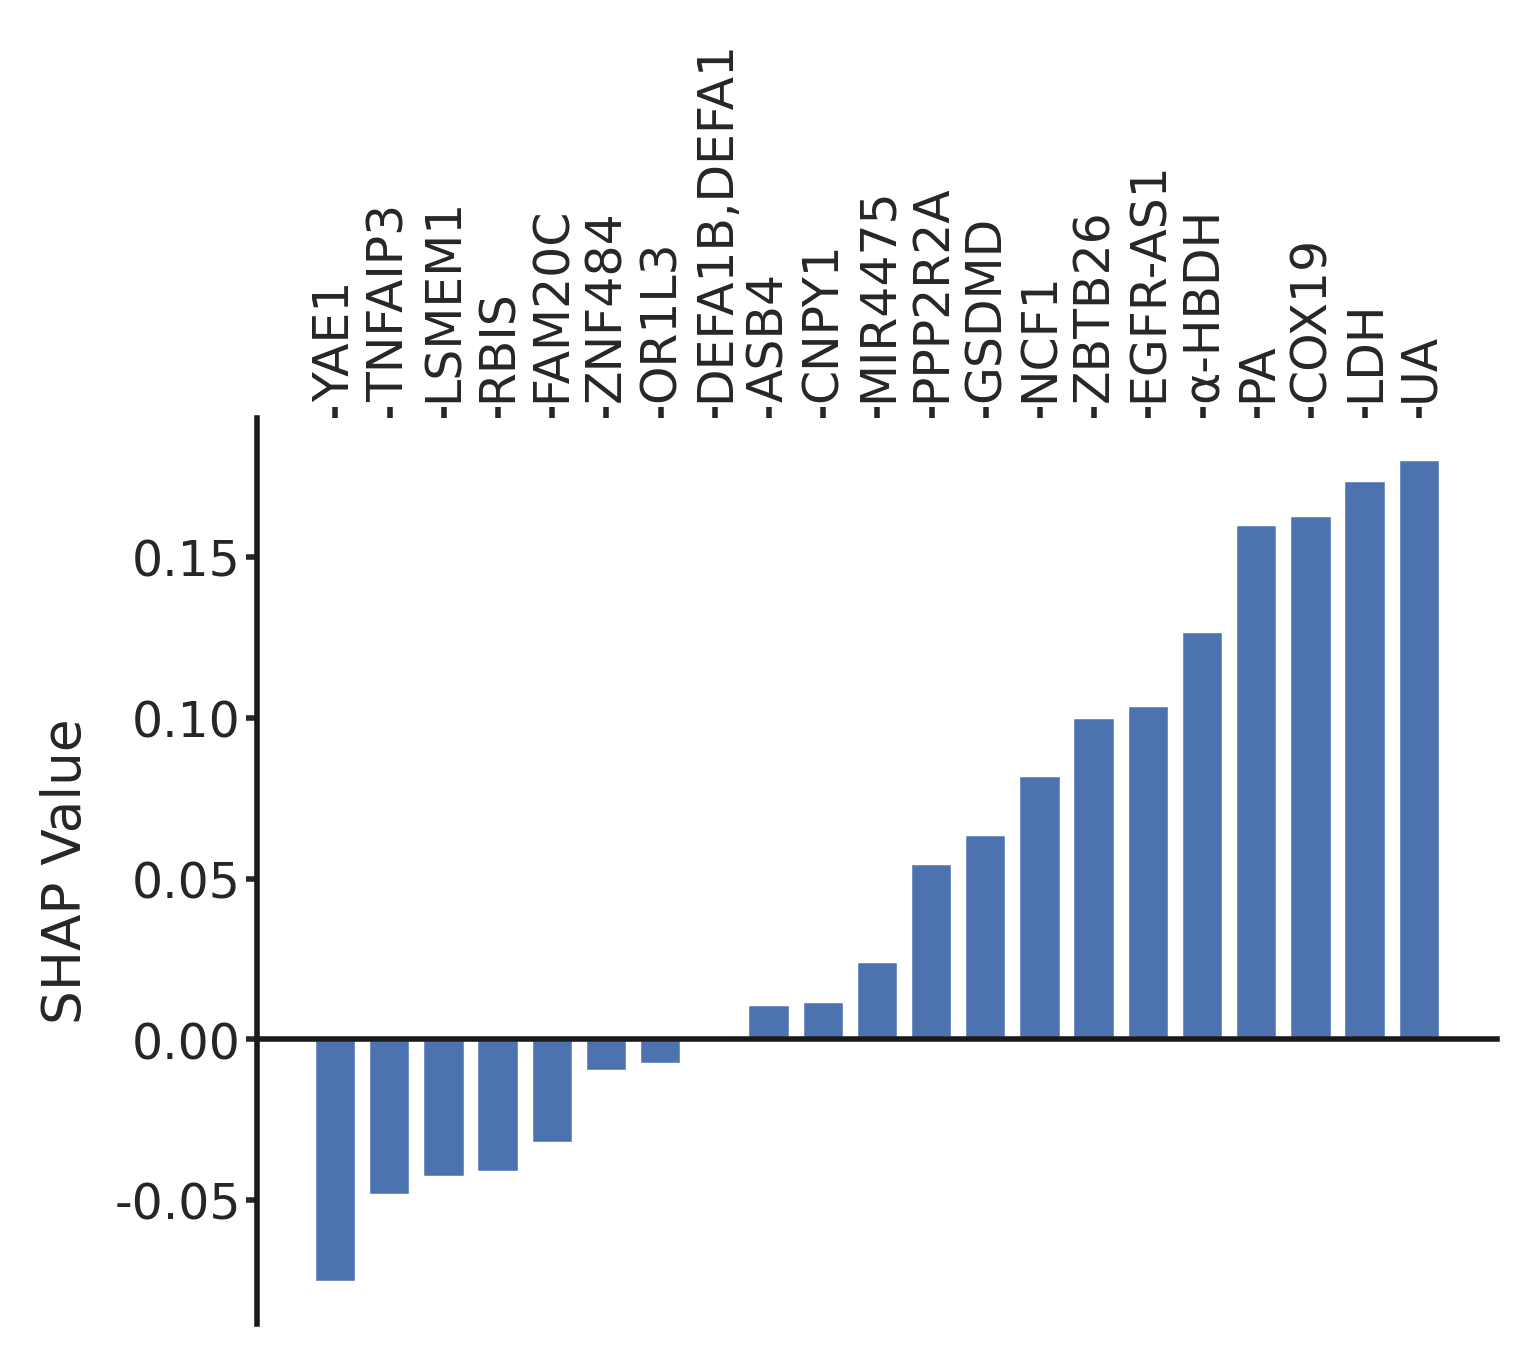

In [63]:
from matplotlib import cm

fig, ax = plt.subplots(1,1, figsize=(4,3))

x_pos = np.arange(preds_df_p_mean_feat.shape[1])
barWidth = 0.8

a = cm.get_cmap('Oranges',len(x_pos))
    
ax.bar(x_pos, preds_df_p_mean_feat.values[0]/preds_df_p_mean_feat.values[0].sum(), width = barWidth)

plt.xticks(x_pos, preds_df_p_mean_feat.columns.tolist())

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_position('zero')
ax.set_xlabel(None)
ax.xaxis.set_ticks_position('top')
ax.set_xticklabels(preds_df_p_mean_feat.columns.tolist(),rotation=90)
ax.set_ylabel('SHAP Value')
ax.tick_params(direction='out', length=2, pad=1)
plt.savefig("results_plt/feat_shap_value_case_8354.pdf", dpi=400, bbox_inches='tight', format='pdf')

In [25]:
preds_df_p_mean_transp = preds_df_p_mean.T.copy()
preds_df_p_mean_transp.rename(columns=tss_genes_map, inplace=True)
preds_df_p_mean_transp.rename(columns={'Uric_acid':'UA'}, inplace=True)

In [31]:
raw_dd_p.rename(columns=tss_genes_map, inplace=True)
raw_dd_p.rename(columns={'Uric_acid':'UA'}, inplace=True)

In [32]:
raw_dd_p

LDH   PPP2R2A    ZBTB26      NCF1     CNPY1  EGFR-AS1    UA  α-HBDH  \
279  296.0  1.982162  0.576668  0.626387  1.693403  1.060684  86.6   225.0   

      MIR4475    ZNF484  ...   TNFAIP3     OR1L3      RBIS  DEFA1B,DEFA1  \
279  0.648853  0.889891  ...  1.086597  1.017354  1.173882      1.542924   

        GSDMD      YAE1     PA    LSMEM1     COX19      ASB4  
279  0.673109  1.388573  146.8  0.418163  2.723887  0.730704  

[1 rows x 21 columns]

In [26]:
preds_df_p_mean_transp

exp_val  y_pred_loglike       LDH   PPP2R2A    ZBTB26      NCF1  \
shap_val -4.406469        0.743376  0.978276  0.308874  0.563923  0.462808   

             CNPY1  EGFR-AS1        UA    α-HBDH  ...   TNFAIP3     OR1L3  \
shap_val  0.067066  0.584421  1.014047  0.714003  ... -0.272942 -0.044422   

              RBIS  DEFA1B,DEFA1     GSDMD      YAE1        PA    LSMEM1  \
shap_val -0.232836      0.005768  0.358266 -0.425315  0.901255 -0.241984   

             COX19      ASB4  
shap_val  0.917017  0.061992  

[1 rows x 23 columns]

In [ ]:
shap.plots.force(preds_df_p_mean_transp['exp_val'].values,
                 preds_df_p_mean_transp.iloc[0,2:].values,
                 features=raw_dd_p,
                 feature_names=preds_df_p_mean_transp.columns.tolist()[2:],
                 matplotlib=True)

In [45]:
preds_df_p_mean_transp = preds_df_p_mean.T

In [44]:
preds_df_p_mean_transp.columns

Index(['exp_val', 'y_pred_loglike', 'LDH', 'PPP2R2A', 'ZBTB26', 'NCF1',
       'CNPY1', 'EGFR-AS1', 'UA', 'α-HBDH', 'MIR4475', 'ZNF484', 'FAM20C',
       'TNFAIP3', 'OR1L3', 'RBIS', 'DEFA1B,DEFA1', 'GSDMD', 'YAE1', 'PA',
       'LSMEM1', 'COX19', 'ASB4'],
      dtype='object')

In [46]:
lab_names = ['LDH', 'Uric_acid', 'α-HBDH', 'PA']
pos_tss_names = ['gene_0_36079', 'gene_1_38365','gene_1_34557', 'gene_1_35660', 'gene_0_34371',
       'gene_1_37604','gene_0_35754', 'gene_0_37102','gene_1_33775', 'gene_1_34781']

neg_tss_names = ['gene_0_37969', 'gene_0_33748','gene_1_33376','gene_0_38356','gene_1_36592','gene_0_34227','gene_0_35092']

In [49]:
lab_shap_sum = preds_df_p_mean_transp[lab_names].sum(1).values[0]
pos_tss_shap_sum = preds_df_p_mean_transp[pos_tss_names].sum(1).values[0]
neg_tss_shap_sum = preds_df_p_mean_transp[neg_tss_names].sum(1).values[0]

In [54]:
lab_shap_sum,pos_tss_shap_sum,neg_tss_shap_sum

(3.6075803408456135, 3.467470077731712, -1.4561025885894237)

In [56]:
lab_shap_w = lab_shap_sum/(lab_shap_sum+pos_tss_shap_sum+neg_tss_shap_sum)
pos_tss_shap_w = pos_tss_shap_sum/(lab_shap_sum+pos_tss_shap_sum+neg_tss_shap_sum)
neg_tss_shap_w = neg_tss_shap_sum/(lab_shap_sum+pos_tss_shap_sum+neg_tss_shap_sum)

In [57]:
lab_shap_w,pos_tss_shap_w,neg_tss_shap_w

(0.6420384118165734, 0.6171030916546485, -0.2591415034712218)

In [58]:
expect_val=preds_df_p_mean_transp['exp_val'].values[0]
prior = sigmoid(expect_val)
postior = preds_df_p_mean_transp['y_pred_loglike'].values[0]
lab_contri = lab_shap_w*(postior-prior)
pos_tss_contri = pos_tss_shap_w*(postior-prior)
neg_tss_shap_w = neg_tss_shap_w*(postior-prior)

In [59]:
lab_contri,pos_tss_contri,neg_tss_shap_w

(0.46953854978407716, 0.4513027342133153, -0.18951658263634427)

In [60]:
lab_contri+pos_tss_contri+neg_tss_shap_w

0.7313247013610482

In [484]:
tss_contri

0.261786151576971

In [65]:
prior+lab_contri+neg_tss_shap_w

0.2920731344422266

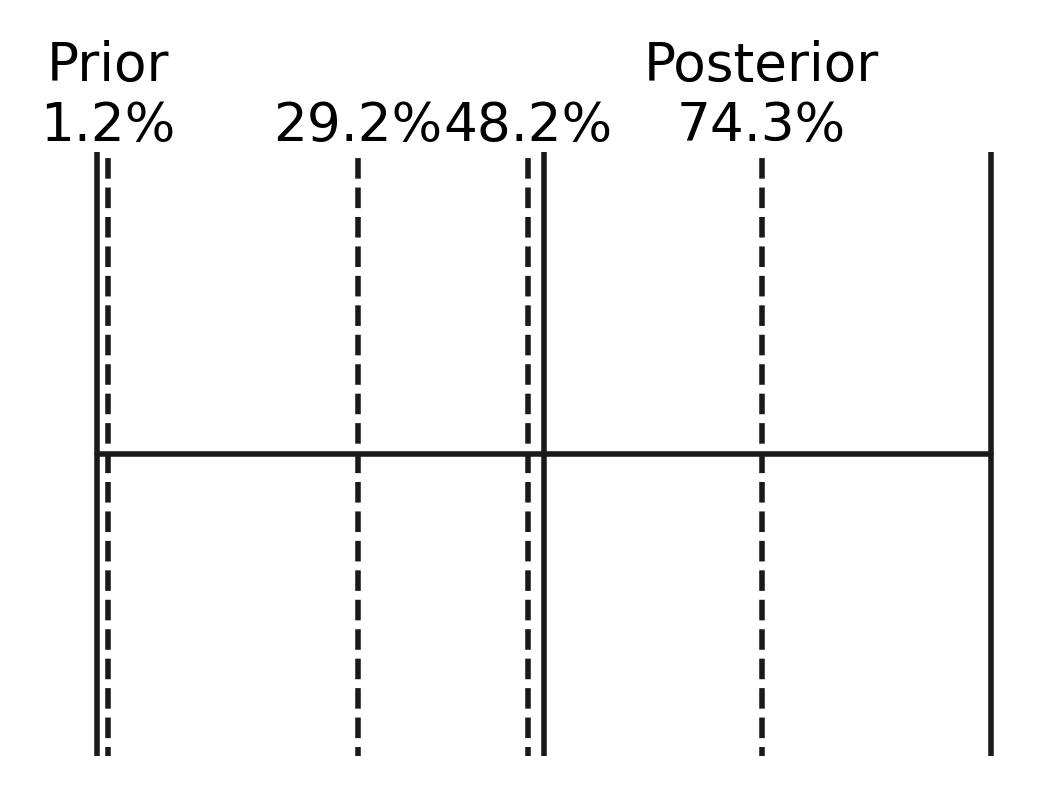

In [67]:
fig, ax = plt.subplots(1,1, figsize=(3,2))
ax.set_xticks([])
ax.set_yticks([])

ax.plot([0,1],[0,0],'k-',linewidth=1)
for x in [0,0.5,1]:
    ax.plot([x,x],[-0.1,0.1],'k-',linewidth=1)

plt.plot([prior,prior],[-0.3,0.1],'k--',linewidth=1)
plt.text(prior,0.05,'%0.1f%%' % (prior*100), horizontalalignment='center', verticalalignment='bottom', color='black')
plt.text(prior,0.06,'Prior', horizontalalignment='center', verticalalignment='bottom', color='black')

plt.plot([prior+lab_contri,prior+lab_contri],[-0.3,0.1],'k--',linewidth=1)
plt.text(prior+lab_contri,0.05,'%0.1f%%' % ((prior+lab_contri)*100), horizontalalignment='center', verticalalignment='bottom', color='black')

plt.plot([prior+lab_contri+neg_tss_shap_w,prior+lab_contri+neg_tss_shap_w],[-0.3,0.1],'k--',linewidth=1)
plt.text(prior+lab_contri+neg_tss_shap_w,0.05,'%0.1f%%' % ((prior+lab_contri+neg_tss_shap_w)*100), horizontalalignment='center', verticalalignment='bottom', color='black')

plt.plot([postior,postior],[-0.3,0.1],'k--',linewidth=1)
plt.text(postior,0.05,'%0.1f%%' % (postior*100), horizontalalignment='center', verticalalignment='bottom', color='black')
plt.text(postior,0.06,'Posterior', horizontalalignment='center', verticalalignment='bottom', color='black')

plt.xlim(-0.02,1.02)
plt.ylim(-0.05, 0.05)
plt.axis('off')

plt.savefig("results_plt/feat_shap_contrib_case_8354.pdf", dpi=400, bbox_inches='tight', format='pdf')
